In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import numpy as np
import warnings
import matplotlib.patches as mpatches
import seaborn as sns

sns.set_style("whitegrid")
plt.rc('font', family='Times New Roman', size=25)

warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)

In [2]:
price = pd.read_excel('market_price_202122.xlsx', sheet_name='Sheet1')
price['date'] = price['date'].astype(str)
price['time'] = price['time'].astype(str)
price['datetime'] = pd.to_datetime(price['date'] + ' ' + price['time'])
price.set_index('datetime', inplace=True)
price.drop(['date', 'time'], axis=1, inplace=True)
price_2022 = price.loc['2022']
df_resampled = price_2022.resample('h').mean() 
price_5min = df_resampled.resample('5min').ffill()  
price_5min.to_csv('price_5min_2022.csv')

In [515]:

with open('solar_panel_data2022.json', 'r') as f:
    data = json.load(f)

times = []
powers = []

for entry in data:
    times.append(entry[0])
    powers.append(entry[1])

for i in range(len(times)):
    times[i] = times[i] / 1000

datetime = pd.to_datetime(times, unit='s')
df = pd.DataFrame({'time': datetime, 'pv': powers})
df = df.set_index('time')
df = df.resample('5min').asfreq()
df = df.fillna(0)
df = df.loc['1/1/2022':'12/30/2022']
df['date'] = df.index.date
df['time'] = df.index.time
df['date'] = pd.to_datetime(df['date']).dt.date
df['time'] = df['time'].astype(str)
df['datetime'] = pd.to_datetime(df['date'].astype(str) + ' ' + df['time'])
df.drop(columns=['date', 'time'], inplace=True)
df.set_index('datetime', inplace=True)
df.pv = df.pv/np.max(df.pv)

In [516]:
load = pd.read_excel("load.xlsx")
load = load.drop(columns=['hour'])
load.Periood = pd.to_datetime(load.Periood)
load.set_index('Periood', inplace=True)
load_res = load.resample('h').mean() 
load_5min = load_res.resample('5min').ffill()  
load_5min = load_5min.shift(periods=-5, freq='H') 
load_5min.fillna(method='ffill', inplace=True)

In [517]:
df['tariff'] = price_5min['tariff']
df['demand'] = load_5min['demand']
# df.to_csv('dataset.csv')

In [518]:
pv_size = 7.5
demand_max = 4.85 # the max is 5 kw but since later we add randomness to data so we keep this value a bit lower.

df.pv = df.pv / np.max(df.pv)
df.pv = df.pv * pv_size

df.demand = df.demand / np.max(df.demand)
df.demand = df.demand * demand_max

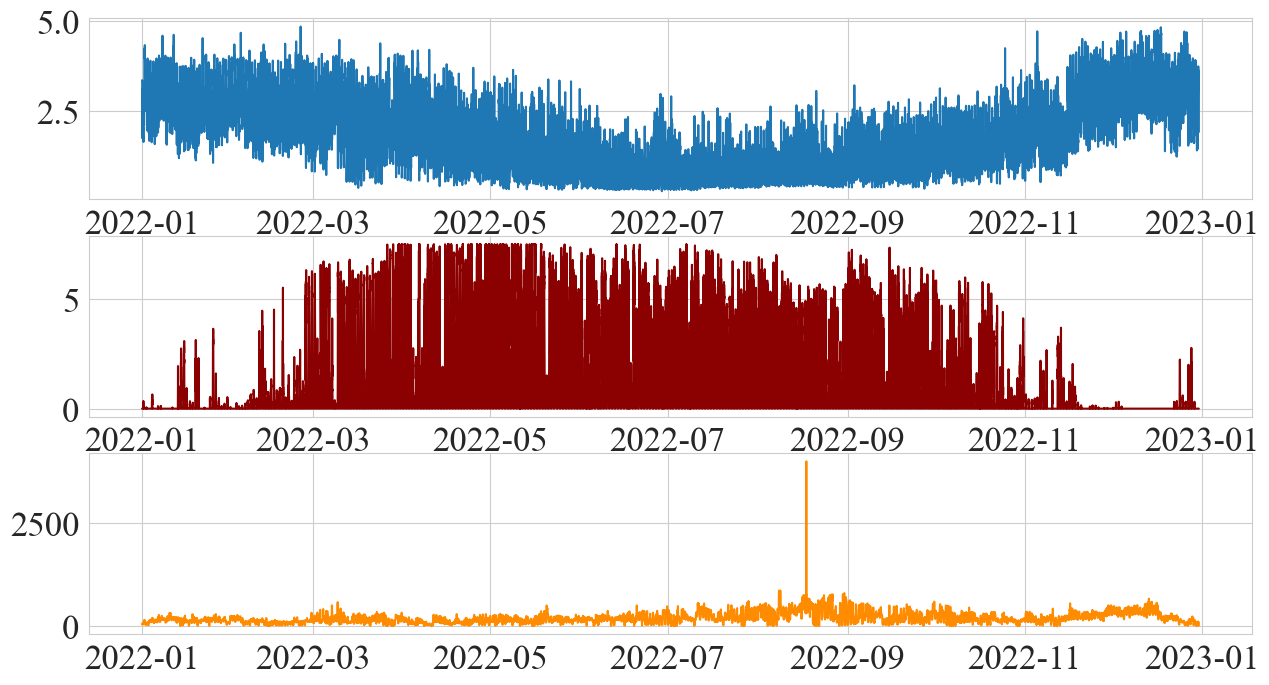

In [519]:
fig1, ax = plt.subplots(3,1, figsize=(15,8))
ax[0].plot(df.index,df.demand)
ax[1].plot(df.index,df.pv, color='darkred')
ax[2].plot(df.index,df.tariff, color='darkorange')
# plt.show()

In [520]:
def add_randomness_with_same_hourly_avg(group):
    mean_val = group.mean()
    random_fluctuations = np.random.rand(len(group)) - 0.5  
    random_fluctuations -= random_fluctuations.mean()
    fluctuation_scale = 0.3 
    group += random_fluctuations * fluctuation_scale
    adjustment = mean_val - group.mean()
    group += adjustment
    return group

df['demand_rand'] = df.groupby(df.index.hour)['demand'].transform(add_randomness_with_same_hourly_avg)
df['demand'] = df['demand_rand']
df = df.drop(['demand_rand'], axis=1)

In [521]:
print(df.head(5))

                      pv  tariff    demand
datetime                                  
2022-01-01 00:00:00  0.0   57.98  3.444307
2022-01-01 00:05:00  0.0   57.98  3.400999
2022-01-01 00:10:00  0.0   57.98  3.258112
2022-01-01 00:15:00  0.0   57.98  3.215289
2022-01-01 00:20:00  0.0   57.98  3.373756


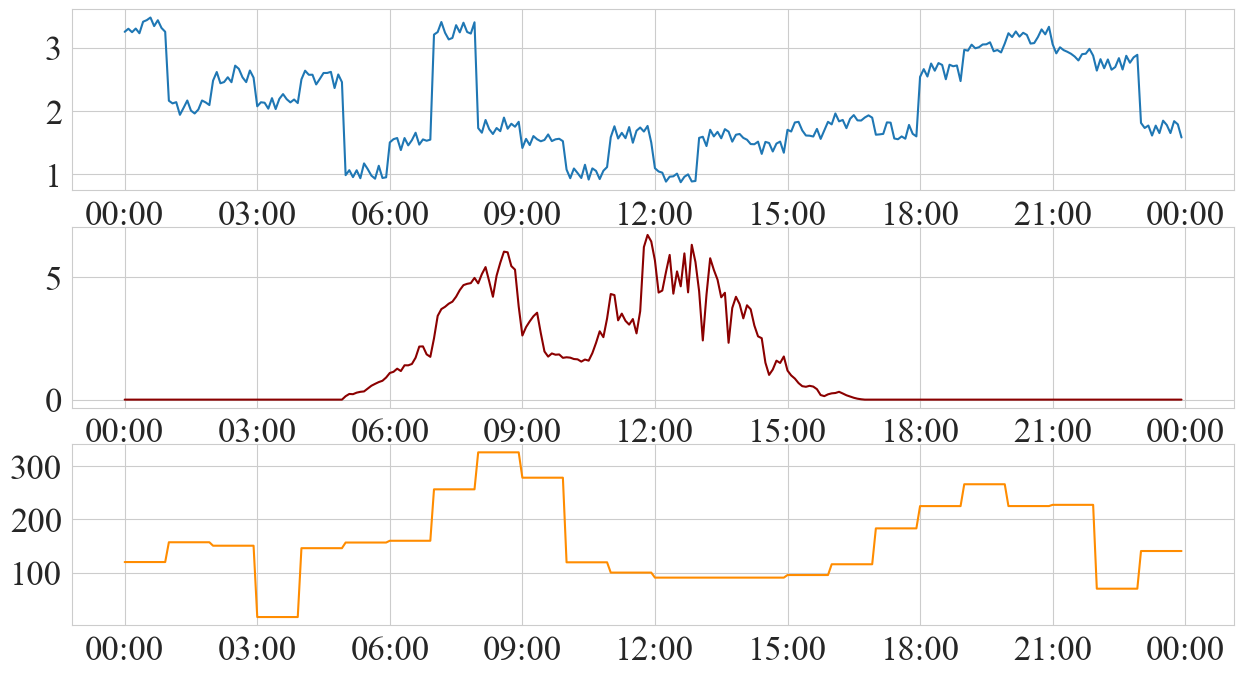

In [522]:
import matplotlib.dates as mdates

fig2, ax = plt.subplots(3,1, figsize=(15,8))
ax[0].plot(df.loc['2022-03-25','demand'])
ax[1].plot(df.loc['2022-03-25','pv'], color='darkred')
ax[2].plot(df.loc['2022-03-25','tariff'], color='darkorange')
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax[2].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.show()

In [523]:
class EnergyStorageModel:
    
    cell_voltage = 3.3  # Volts (V)
    cell_stored_energy = 3.63  # Watt-hour (Wh)
    cell_nominal_capacity = 1.1  # Ampere-hour (Ah)
    internal_resistance = 12.6  # milliohms (mΩ)
    battery_charge_efficiency = 0.96  # max 1
    battery_discharge_efficiency = 0.96  # max 1
    max_continuous_discharge_current = 30  # Amps (A)
    max_continuous_charge_current = 4  # Amps (A)
    delta_dod = 75  # Percentage (%) - Depth of Discharge variation
    eol = 70  # Percentage (%) - End of Life criteria
    cycle_life = 2000  # Cycles for 100% Depth of Discharge (DOD)
    calendar_life = 10  # Years
    
    soc = 30.0  # State of Charge, as a percentage
    soh = 100.0  # State of Health, as a percentage
    soc_min = 15.0  # Minimum State of Charge, as a percentage
    soc_max = 90.0  # Maximum State of Charge, as a percentage
    current_max = 30.0  # Current, in Amps (A)
    power_max = 10200.0  # Power, in Watts (W)
    voltage_max = 340.0  # Voltage, in Volts (V)
    capacity = 15000 # energy storage capacity (Wh)
    soc_init = 50.0  # Initial State of Charge, as a percentage
    c_rate_charge = 1.0  # Charge  c rate
    c_rate_discharge = 1.0 # Discharge c rate
    cell_series = 100  # Number of cells in series
    parallel_branches = 16  # Number of parallel branches
    
    k_s1 =  -4.092e-4  # unit: None
    k_s2 = -2.167     # unit: None
    k_s3 = 1.408e-5  # unit: None
    k_s4 = 6.13 # unit: None
    E_a = 78.06  # unit: "kJ/mol"
    R = 8.314  # unit: "J/(k.mol)"
    T_ref = 298.15 # "unit": "K"
    T_i = 303.15   # "unit": "K"
    
    def __repr__(self):
        return f"""Energy Storage Model Specifications:
        - Cell Voltage: {self.cell_voltage} V
        - Cell Stored Energy: {self.cell_stored_energy} Wh
        - Cell Nominal Capacity: {self.cell_nominal_capacity} Ah
        - Internal Resistance: {self.internal_resistance} mΩ
        - Battery charge Efficiency: {self.battery_charge_efficiency} %
        - Battery discharge Efficiency: {self.battery_discharge_efficiency} %
        - Continuous Discharge Current: {self.max_continuous_discharge_current} A
        - Continuous Charge Current: {self.max_continuous_charge_current} A
        - ΔDoD: {self.delta_dod} %
        - EoL: {self.eol} %
        - Cycle Life, 100% DOD: {self.cycle_life} Cycles
        - Calendar Life: {self.calendar_life} Years
        - SOC: {self.soc} %
        - SOH: {self.soh} %
        - SOC Min: {self.soc_min} %
        - SOC Max: {self.soc_max} %
        - Current Max: {self.current_max} A
        - Power Max: {self.power_max} W
        - Voltage Max: {self.voltage_max} V
        - Capacity : {self.capacity} kWh
        - soc inti: {self.soc_init} % 
        - c rate charge: {self.c_rate_charge} h-1
        - c rate discharge: {self.c_rate_discharge} h-1
        - cell series number: {self.cell_series} 
        - parallel branches : {self.parallel_branches} 
        - Ks1: {self.k_s1} 
        - Ks2: {self.k_s2} 
        - Ks3: {self.k_s3} 
        - Ks4: {self.k_s4} 
        - Ea: {self.E_a} kJ/mol
        - R : {self.R} J/(k.mol)
        - T ref: {self.T_ref} K
        - T init: {self.T_i} K """
        
ess = EnergyStorageModel()

In [524]:
from scipy.integrate import quad

def f_soc(Q, Qmax):

    soc = Q / Qmax
    return soc

def f_soc_avg(Qt_1, Qt, Qmax):
    
    delta_Qt = Qt - Qt_1
    soc_avg, _ = quad(lambda Q: f_soc(Q, Qmax), Qt_1, Qt)
    soc_avg = soc_avg / delta_Qt
    return soc_avg

def f_soc_dev(Qt_1, Qt, Qmax):
    
    delta_Qt = Qt - Qt_1
    soc_avg = f_soc_avg(Qt_1, Qt, Qmax)
    integral_result, _ = quad(lambda Q: (f_soc(Q, Qmax) - soc_avg) ** 2, Qt_1, Qt)
    soc_dev = np.sqrt(abs((3 / delta_Qt) * integral_result))
    return soc_dev

def f_Fi(soc_dev, soc_avg):
    
    F = (ess.k_s1 * soc_dev * np.exp(ess.k_s2 * soc_avg) + ess.k_s3 * np.exp(ess.k_s4 * soc_dev))
    return F

def f_c_cycle(F, Q, Ea, R, T, T_ref):

    c_cycle = sum(F[i] * abs(Q[i]-Q[i-1]) * np.exp(( -Ea / R ) * (1 / T - 1 / T_ref)) for i in range(len(F)))
    return c_cycle

def f_c_cal_1h(soc_1h_avg):

    c_cal_1h = (6.6148 * soc_1h_avg + 4.6404) * 10**-6
    return c_cal_1h

def f_c_cal(c_cal_1h_list):

    c_cal = sum(c_cal_1h_list)
    return c_cal

def f_c_cycle_day(c_cycle_1h_list):

    c_cycle_day= sum(c_cycle_1h_list)
    return c_cycle_day

def f_soh(c_cal, c_cycel, c_nm):
    c_fd = c_cal + 100 * c_cycel/c_nm
    # soh = 100 - c_fd
    return c_fd

In [525]:
def soh_daily_change(Qt, Qmax):
    
    c_cal_day = []
    c_cycle_day = []
    
    for i in range(int(len(Qt)/24)): # 0-23
        Fi = []
        Qi = []
        socAvg_1h = 0.0
        
        # first we calculate for each hour: 
        for j in range(12): # 0-11
            if i*12+j-1 > 0 : 
                socAvg = f_soc_avg(Qt[i*12+j-1], Qt[i*12+j], Qmax)
                socDev = f_soc_dev(Qt[i*12+j-1], Qt[i*12+j], Qmax)
                Fi.append(f_Fi(socAvg, socDev))
                Qi.append(Qt[i*12+j])
                socAvg_1h += socAvg 
                  
        c_cycle_1h  = f_c_cycle(Fi, Qi, ess.E_a, ess.R, ess.T_i, ess.T_ref)
        c_cal_1h = f_c_cal_1h(socAvg_1h/12)
        c_cal_day.append(c_cal_1h)
        c_cycle_day.append(c_cycle_1h)
        
    c_cal = f_c_cal(c_cal_day)
    c_cycle = f_c_cycle_day(c_cycle_day)
    delta_soh = f_soh(c_cal, c_cycle, Qmax)       
    if delta_soh< 0: 
        delta_soh = 0
    return delta_soh

In [526]:
# Qmax = 100 
# Qt = [8, 17, 14, 10, 50, 2, 10, 4, 10, 14, 5, 6, 8, 17, 14, 10, 5, 16, 10, 4, 18, 14, 5, 6, 8, 17, 14, 10, 5, 2, 24, 4, 18, 14, 5, 6] 
# Qt_1 = [16, 16, 8, 10, 7, 2, 3, 15, 17, 16, 13, 3, 16, 16, 8, 10, 7, 2, 3, 15, 17, 16, 13, 3, 16, 16, 8, 10, 7, 2, 3, 15, 17, 16, 13, 3]

In [527]:
# print(f"delta_SoH: {soh_daily_change(Qt, Qmax)}")

In [528]:
class ResidentialElectricityDistribution:
    def __init__(self, load_current, load_voltage, load_power):
        
        self.bus_voltage = 350  # Volts (V)
        self.load_current = load_current  # Amperes (A)
        self.load_voltage = load_voltage  # Volts (V)
        self.load_power = load_power      # Watts (W)

    def update(self, load_current=None, load_voltage=None, load_power=None):

        if load_current is not None:
            self.load_current = load_current
        if load_voltage is not None:
            self.load_voltage = load_voltage
        if load_power is not None:
            self.load_power = load_power

    def display_status(self):
        
        print(f"Bus Voltage: {self.bus_voltage} V")
        print(f"load Current: {self.load_current} A")
        print(f"load Voltage: {self.load_voltage} V")
        print(f"load Power: {self.load_power} W")

nZEb = ResidentialElectricityDistribution(load_current=10, load_voltage=230, load_power=2300)

In [702]:
class EnergyRouter:
    def __init__(self, efficiency, power_max, current_max):
        
        self.efficiency = efficiency
        self.power_max = power_max
        self.current_max = current_max
        
    def update(self, efficiency=None, power_max=None, current_max=None):
    
        if efficiency is not None:
            self.efficiency = efficiency
        if power_max is not None:
            self.power_max = power_max
        if current_max is not None:
            self.current_max = current_max   
    
    def __repr__(self):
        return f"""Energy Router Specifications:
        - Conversion efficiency: {self.efficiency} %
        - Power max ratio: {self.power_max} W 
        - Current max ratio: {self.current_max}"""
      
er = EnergyRouter(efficiency=0.98, power_max=10000, current_max= 22.5)  

In [703]:
class PhotoVoltaic:
    def __init__(self, efficiency, power, current, life_span):
        
        self.efficiency = efficiency
        self.power = power
        self.current = current
        self.life_span  = life_span
        
    def update(self, efficiency=None, power=None, current=None, life_span=None):
    
        if efficiency is not None:
            self.efficiency = efficiency
        if power is not None:
            self.power = power
        if current is not None:
            self.current = current   
        if life_span is not None:
            self.life_span = life_span
    
    def __repr__(self):
        return f"""Photovoltaic Specifications:
        - Conversion efficiency: {self.efficiency} %
        - Power ratio: {self.power} W 
        - Current ratio: {self.current} A
        - Life span: {self.life_span} Years"""
      
pv = PhotoVoltaic(efficiency=1, power=7500, current= 30, life_span=25)  

In [704]:
class GridSpecs:
    def __init__(self, efficiency, power_max, current_max, voltage):
        
        self.efficiency = efficiency
        self.power_max = power_max
        self.current_max = current_max
        self.voltage  = voltage
        
    def update(self, efficiency=None, power_max=None, current_max=None, voltage=None):
    
        if efficiency is not None:
            self.efficiency = efficiency
        if power_max is not None:
            self.power_max = power_max
        if current_max is not None:
            self.current_max = current_max   
        if voltage is not None:
            self.voltage = voltage
    
    def __repr__(self):
        return f"""Grid Specifications:
        - Conversion efficiency: {self.efficiency} %
        - Power Max ratio: {self.power_max} W 
        - Current Max ratio: {self.current_max} A
        - Voltage: {self.voltage} V"""
      
grid = GridSpecs(efficiency=1, power_max=10000, current_max= 30, voltage=220)  

In [532]:
class LoadSpecs:
    def __init__(self, efficiency, power_max, current_max, voltage):
        
        self.efficiency = efficiency
        self.power_max = power_max
        self.current_max = current_max
        self.voltage  = voltage
        
    def update(self, efficiency=None, power_max=None, current_max=None, voltage=None):
    
        if efficiency is not None:
            self.efficiency = efficiency
        if power_max is not None:
            self.power_max = power_max
        if current_max is not None:
            self.current_max = current_max   
        if voltage is not None:
            self.voltage = voltage
    
    def __repr__(self):
        return f"""Load Specifications:
        - Conversion efficiency: {self.efficiency} %
        - Power Max ratio: {self.power_max} W 
        - Current Max ratio: {self.current_max} A
        - Voltage: {self.voltage} V"""
      
load = LoadSpecs(efficiency=1, power_max=5000, current_max= 30, voltage=220)  

In [533]:
class SimulationVariablesRange:
    def __init__(self, BESS_size, PV_size, ER_size, C_rate_charge, C_rate_discharge):
        self.BESS_size = BESS_size  # in kWh
        self.PV_size = PV_size      # in kWp
        self.ER_size = ER_size      # in kW
        self.C_rate_charge = C_rate_charge  # in h-1
        self.C_rate_discharge = C_rate_discharge  # in h-1
        
        self.validate_specs()

    def validate_specs(self):
        
        if not 1 <= self.BESS_size <= 15:
            raise ValueError("BESS size must be between 1 and 15 kWh.")
        
        if not 1 <= self.PV_size <= 20:
            raise ValueError("PV size must be between 1 and 20 kWp.")
        
        if not 2.5 <= self.ER_size <= 20 or (self.ER_size - 2.5) % 2.5 != 0:
            raise ValueError("ER size must be between 2.5 and 20 kW with steps of 2.5 kW.")
        
        if not 0 <= self.C_rate_charge <= 1.35 or (self.C_rate_charge * 10) % 1 != 0:
            raise ValueError("C-rate charge must be between 0 and 1.35 C with steps of 0.1.")
        
        if not 0 <= self.C_rate_discharge <= 5 or (self.C_rate_discharge * 10) % 1 != 0:
            raise ValueError("C-rate discharge must be between 0 and 5 C with steps of 0.1.")

# try:
#     system_specs = SimulationVariablesRange(BESS_size=15, PV_size=15, ER_size=5, C_rate_charge=0.5, C_rate_discharge=1)
#     print("Specs are valid.")
# except ValueError as e:
#     print(e)   

In [534]:
class FinancialTechnicalParameters:
    def __init__(self):
        # Financial and Technical Parameters
        self.unit_cost_bess = 750  # €/kWh - Li-ion BESS cost
        self.annual_cost_reduction_bess= 0.12  # BESS annual price reduction
        self.bess_value_size_reduction = 0.03  # BESS value/size reduction per kWh
        self.unit_cost_pv = 1300  # €/kW - PV cost
        self.pv_value_size_reduction = 0.04  # PV value/size reduction per kW
        self.pv_lifespan = 30  # years - PV lifetime
        self.unit_cost_er= 250  # €/kW - ER cost
        self.er_lifespan = 15  # years - ER lifetime
        self.unit_cost_emu = 200  # €/unit - EMU cost
        self.load_annual_increase = 0.03  # Load annual increase rate %
        self.utility_annual_inflation = 0.05  # Utility tariffs inflation rate %
        self.annual_inflation_rate = 0.04  # Annual inflation rate %
        self.interest_rate= 0.035  # Interest rate
        self.feed_in_tariff_coefficient = 0.8  # Feed-in tariff coefficient
        self.annual_maintenance_cost_ratio = 0.01  # % "1% of setup cost"  # Maintenance cost
        self.network_service_charge = 0.01 # for each kWh
        self.energy_exchange_cost = 0.01 # for each kWh

    def display_parameters(self):
        for attr, value in self.__dict__.items():
            print(f"{attr}: {value}")

economic_params = FinancialTechnicalParameters()
# economic_params.display_parameters()

In [535]:
df['day'] = df.groupby(df.index.date).ngroup() + 1
unique_days = df['day'].unique()

# df.to_csv('dataset.csv')
df = df.reset_index()

In [536]:
def ess_soc_to_voltage (model):
    soc = value(model.ess_soc(t))
    voltage = (soc+735)/250
    voltage = int(voltage*100)
    # voltage = 330
    return voltage

In [537]:
import numpy as np

def calculate_delta_soh (model, discharge_current, charge_current, interval):
    discharge_current_np = np.array(discharge_current)
    charge_current_np = np.array(charge_current)
    Q_processed = (discharge_current_np + charge_current_np) * interval
    Q_max =  value(model.ess_capacity)/ value(model.ess_voltage[t])
    soh_delta  = soh_daily_change(Q_processed,Q_max)
    return soh_delta

In [545]:
from pyomo.environ import *
from pyomo.environ import NonNegativeReals, Reals
import math

initial_soh = 100 
initial_soc = 20 

soh_values = [initial_soh]  
soc_values = [initial_soc]
interval = 5 / 60
t = 0 


    
    
# logs: 
ess_to_load_log = {}
ess_to_grid_log = {}
ess_soc_log = {}
ess_voltage_log={}
ess_charge_power_log = {}
ess_charge_current_log = {}
ess_discharge_power_log = {}
ess_discharge_current_log = {}
ess_total_power_flow_log = {}
pv_to_load_log = {}
pv_to_grid_log = {}
pv_to_ess_log = {}
grid_to_load_log = {}
grid_to_ess_log = {}

simulation_period = unique_days[120:130]

for i, day in enumerate(simulation_period): 
    daily_df= df.loc[df['day'] == day]  
    daily_df.index = np.arange(0, len(daily_df))
    daily_df['tariff'] = daily_df['tariff'] #/12e6      
    daily_df['pv'] = daily_df['pv']*1000
    daily_df['demand'] = daily_df['demand']*1000
    

    
    error_5 = np.random.normal(loc=0, scale=0.05, size=len(daily_df))
    error_10 = np.random.normal(loc=0, scale=0.1, size=len(daily_df))
    error_20 = np.random.normal(loc=0, scale=0.2, size=len(daily_df))
    
    daily_df['demand_5'] = daily_df['demand']
    daily_df['demand_5'] += daily_df['demand']*error_5 
    daily_df['demand_5']  = daily_df['demand_5'] .clip(upper=5000)
    
    daily_df['pv_5'] = daily_df['pv']
    daily_df['pv_5'] += daily_df['pv']*error_5 
    daily_df['pv_5']  = daily_df['pv_5'] .clip(upper=7500)
    
    # load_10 = load.copy()
    # load_10['demand'] += load['demand']*error_10 
    # load_10['demand'] = load_10['demand'].clip(upper=5)
    # 
    # load_20 = load.copy()
    # load_20['demand'] += load['demand']*error_20 
    # load_20['demand'] = load_20['demand'].clip(upper=5)
    
    model = ConcreteModel()
    model.T = RangeSet(0, 287)
    model.interval_duration = Param(initialize=1/12)  # 5 minutes in hours
    # ess params:
    model.ess_capacity = Param(initialize=ess.capacity, within=NonNegativeReals) 
    model.ess_soc_max = Param(initialize=ess.soc_max, within=NonNegativeReals)  
    model.ess_soc_min = Param(initialize=ess.soc_min, within=NonNegativeReals)  
    model.ess_soh = Param(model.T, initialize=soh_values[i], within=NonNegativeReals) 
    model.ess_soc_init = Param(initialize=soc_values[i], within=NonNegativeReals)
    model.ess_unit_price = Param(initialize=economic_params.unit_cost_bess, within=NonNegativeReals) 
    model.ess_charge_efficiency = Param(initialize=ess.battery_charge_efficiency, within=NonNegativeReals) # dc to dc
    model.ess_discharge_efficiency = Param(initialize=ess.battery_discharge_efficiency, within=NonNegativeReals) # dc to dc
    model.ess_current_charge_max= Param(initialize=ess.c_rate_charge * ess.parallel_branches * ess.cell_nominal_capacity, within=NonNegativeReals)  
    model.ess_current_discharge_max= Param(initialize=ess.c_rate_discharge * ess.parallel_branches * ess.cell_nominal_capacity, within=NonNegativeReals)  
    model.ess_voltage_max= Param(initialize=ess.voltage_max, within=NonNegativeReals) 
    model.ess_current_max= Param(initialize=ess.current_max, within=NonNegativeReals) 
    model.ess_power_max= Param(initialize=ess.power_max, within=NonNegativeReals)
        
    # pv params:
    model.pv_power = Param(model.T, initialize = daily_df['pv_5'].to_dict(), within=NonNegativeReals)
    # model.pv_efficiency = Param(initialize= pv.efficiency, within=NonNegativeReals)  # dc to dc

    # grid params:
    model.grid_tariff = Param(model.T, initialize = daily_df['tariff'].to_dict(), within=NonNegativeReals)
    model.grid_c_fx = Param(initialize =economic_params.network_service_charge, within=NonNegativeReals)
    model.grid_c_ex = Param(initialize =economic_params.energy_exchange_cost, within=NonNegativeReals) 
    model.grid_fit_cof = Param(initialize =economic_params.feed_in_tariff_coefficient, within=NonNegativeReals) 
    model.grid_power_max  = Param(initialize=grid.power_max, within=NonNegativeReals) 
    model.grid_current_max = Param(initialize=grid.current_max, within=NonNegativeReals) 
    model.grid_voltage = Param(initialize=grid.voltage, within=NonNegativeReals)
    
    # load params:
    model.load_power = Param(model.T, initialize = daily_df['demand_5'].to_dict(), within=NonNegativeReals)
    model.load_current_max = Param(initialize = load.current_max, within=NonNegativeReals)  
    model.load_voltage  = Param(initialize = load.voltage, within=NonNegativeReals) 
    model.load_power_max  = Param(initialize=load.power_max, within=NonNegativeReals) 
    # model.load_efficiency = Param(initialize=load.efficiency) 

    # er params: 
    model.er_efficiency = Param(initialize= er.efficiency, within=NonNegativeReals)  # dc to ac 
    model.er_power_max = Param(initialize= er.power_max, within=NonNegativeReals)
    model.er_current_max = Param(initialize= er.current_max, within=NonNegativeReals)
    

    # variables & constraints & relations
    
    # ess variables:
    model.ess_soc = Var(model.T, bounds= (model.ess_soc_min, model.ess_soc_max)) # dependent to processed energy from ess
    # model.ess_power = Var(model.T, bounds= (0 , model.ess_power_max))  # dependent to power charge + power discharge 
    model.ess_charge_power = Var(model.T, bounds= (0 , model.ess_power_max)) # main decision variable
    model.ess_discharge_power = Var(model.T, bounds= (0 , model.ess_power_max)) # main decision variable
    model.ess_voltage = Var(model.T, bounds= (0 , model.ess_voltage_max))  # dependent to power and soc level 
    model.ess_to_load_power = Var(model.T, bounds= (0, model.er_power_max), domain=NonNegativeReals) 
    model.ess_to_grid_power = Var(model.T, bounds= (0, model.er_power_max), domain=NonNegativeReals)
    
    # pv variables:
    model.pv_to_ess_power = Var(model.T, bounds= (0, model.er_power_max) , domain=NonNegativeReals) 
    model.pv_to_grid_power = Var(model.T, bounds=(0, model.er_power_max) , domain=NonNegativeReals) 
    model.pv_to_load_power = Var(model.T, bounds= (0, model.er_power_max), domain = NonNegativeReals) 
    
    # grid variables:   
    model.grid_to_load_power = Var(model.T, bounds= (0, model.grid_power_max) ,domain=NonNegativeReals)  
    model.grid_to_ess_power = Var(model.T, bounds= (0,  model.er_power_max), domain=NonNegativeReals) 
    
    
    def soc_update_rule(model, t):
        if t == model.T.first():
            return model.ess_soc[t] == value(model.ess_soc_init)
        else:
            charge_soc = (model.ess_charge_power[t] * interval) / value(model.ess_capacity) # * value(model.ess_charge_efficiency)
            discharge_soc = (model.ess_discharge_power[t]  * interval) / value(model.ess_capacity)  #/ value(model.ess_discharge_efficiency)
            return model.ess_soc[t] == model.ess_soc[t-1] - discharge_soc*100 + charge_soc*100
    model.ess_soc_update = Constraint(model.T, rule=soc_update_rule)
    
    
    def ess_voltage_constraint_rule(model, t):
        if t == model.T.first():
            return model.ess_voltage[t] == (model.ess_soc_init+735)*ess.cell_series/250
        else:
            # return model.ess_voltage[t] == ess_soc_to_voltage(model)
            return model.ess_voltage[t] ==  (model.ess_soc[t-1]+735)*ess.cell_series/250
    model.ess_voltage_constraint = Constraint(model.T, rule=ess_voltage_constraint_rule)
    

    def charge_current_limit_rule(model, t):
        return model.ess_charge_power[t] / model.ess_voltage[t] <= model.ess_current_charge_max
    model.charge_current_limit_constraint = Constraint(model.T, rule=charge_current_limit_rule)

    def discharge_current_limit_rule(model, t):
        return model.ess_discharge_power[t] / model.ess_voltage[t] <= model.ess_current_discharge_max
    model.discharge_current_limit_constraint = Constraint(model.T, rule=discharge_current_limit_rule)

    # def ess_power_constraint_rule(model, t):  
    #     return model.ess_charge_power[t] + model.ess_discharge_power[t] == model.ess_power[t] 
    # model.ess_power_constraint_constrain = Constraint(model.T, rule=ess_power_constraint_rule)
    
    
    # def ess_max_deliverable_energy_rule(model, t):
    #     return model.ess_to_load_power[t] + model.ess_to_grid_power[t] <= (model.ess_soc[t] - model.ess_soc_min) * model.ess_capacity /interval 
    # model.ess_max_deliverable_energy_constrain = Constraint(model.T, rule=ess_max_deliverable_energy_rule)

    # def ess_charge_power_check_rule(model, t): 
    #     return model.ess_charge_power[t] == (model.pv_to_ess_power[t] * value(model.er_efficiency) + model.grid_to_ess_power[t] * value(model.er_efficiency)) * model.ess_charge_efficiency 
    # model.ess_charge_power_check_constrain = Constraint(model.T, rule=ess_charge_power_check_rule)
    
    def ess_charge_power_check_rule(model, t): # ideal case
        return model.ess_charge_power[t] == model.pv_to_ess_power[t] + model.grid_to_ess_power[t] 
    model.ess_charge_power_check_constrain = Constraint(model.T, rule=ess_charge_power_check_rule)
    
    # def ess_discharge_power_check_rule(model, t):
    #     return model.ess_discharge_power[t] == (model.ess_to_load_power[t] * value(model.er_efficiency) + model.ess_to_grid_power[t] * value(model.er_efficiency) ) * model.ess_discharge_efficiency
    # model.ess_discharge_power_check_constrain = Constraint(model.T, rule=ess_discharge_power_check_rule)
    
    def ess_discharge_power_check_rule(model, t): # ideal case
        return model.ess_discharge_power[t] == model.ess_to_load_power[t] + model.ess_to_grid_power[t]
    model.ess_discharge_power_check_constrain = Constraint(model.T, rule=ess_discharge_power_check_rule)
    
    def ess_discharge_charge_overlap_rule(model, t):
        return model.ess_charge_power[t] * model.ess_discharge_power[t] ==0 
    model.ess_discharge_charge_overlap_constrain = Constraint(model.T, rule=ess_discharge_charge_overlap_rule)
    
    def ess_grid_power_overlap_rule(model, t):
        return model.ess_to_grid_power[t] * model.grid_to_ess_power[t] ==0 
    model.ess_grid_power_overlap_constrain = Constraint(model.T, rule=ess_grid_power_overlap_rule)

    # ASK OLEKSANDR 
    # def pv_grid_to_ess_overlap_rule(model, t):
    #     return model.pv_to_ess_power[t] * model.grid_to_ess_power[t] == 0
    # model.pv_grid_to_ess_overlap_constrain = Constraint(model.T, rule=pv_grid_to_ess_overlap_rule)
    
    # def ess_charge_power_limit_er_rule(model, t):
    #     return model.grid_to_ess_power[t] + model.pv_to_ess_power[t] <= value(model.er_power_max)
    # model.ess_charge_power_limit_er_constrain = Constraint(model.T, rule=ess_charge_power_limit_er_rule)

    # def ess_discharge_power_limit_er_rule(model, t):
    #     return model.ess_to_grid_power[t] + model.ess_to_load_power[t] <= value(model.er_power_max)
    # model.ess_discharge_power_limit_er_constrain = Constraint(model.T, rule=ess_discharge_power_limit_er_rule)



    def pv_generation_consume_rule(model, t):
        return model.pv_to_grid_power[t] + model.pv_to_load_power[t] + model.pv_to_ess_power[t] == model.pv_power[t]
    model.pv_generation_consume_constraint = Constraint(model.T, rule=pv_generation_consume_rule)

    # def pv_to_ess_efficiency_rule(model, t):
    #     return model.pv_to_ess_power[t] * model.ess_charge_efficiency <= model.ess_charge_power[t]
    # model.pv_to_battery_efficiency_constraint = Constraint(model.T, rule=pv_to_ess_efficiency_rule)
    
    # def pv_delivery_power_limit_er_rule(model, t):
    #     return model.pv_to_grid_power[t] + model.pv_to_load_power[t] + model.pv_to_ess_power[t] <=value(model.er_power_max)
    # model.pv_delivery_power_limit_er_constrain = Constraint(model.T, rule=pv_delivery_power_limit_er_rule)
    
    # load variables:
    # def energy_demand_response_rule(model, t):
    #     return model.pv_to_load_power[t] * value(model.er_efficiency) + model.ess_to_load_power[t] * value(model.er_efficiency) * value(model.ess_discharge_efficiency) +  model.grid_to_load_power[t] == model.load_power[t]
    # model.energy_demand_response_constrain = Constraint(model.T, rule=energy_demand_response_rule)
    
    def energy_demand_response_rule(model, t):
        return model.pv_to_load_power[t] + model.ess_to_load_power[t] +  model.grid_to_load_power[t] == model.load_power[t]
    model.energy_demand_response_constrain = Constraint(model.T, rule=energy_demand_response_rule)
    
    # def grid_delivery_power_limit_rule(model, t):
    #     return model.grid_to_ess_power[t] + model.grid_to_load_power[t] <= value(model.grid_power_max)
    # model.grid_delivery_power_limit_constrain = Constraint(model.T, rule=grid_delivery_power_limit_rule)

    def grid_power_flow_rule(model, t):
        return (model.grid_to_ess_power[t] + model.grid_to_load_power[t]) * (model.ess_to_grid_power[t] + model.pv_to_grid_power[t]) == 0
    model.grid_power_flow_constrain = Constraint(model.T, rule=grid_power_flow_rule)


    def grid_cost(model, t):
            Gr_c_j = (model.grid_to_ess_power[t] + model.grid_to_load_power[t] ) * model.grid_tariff[t] 
            return Gr_c_j
    
    # + model.grid_c_fx + model.grid_c_ex * (model.grid_to_ess_power[j]  + model.grid_to_load_power[j] + model.ess_to_grid_power[j] + model.pv_to_grid_power[j]) 
    def ess_cost(model, t):
        if t == model.T.first():
            return 0
        else:
            delta_soh_j = 0 # model.ess_soh[t-1] - model.ess_soh[t]
            Es_c_j = delta_soh_j * (model.ess_unit_price * model.ess_capacity/((100-ess.eol)*1000)) 
            return Es_c_j
    
    def fp_cost(model, t):
            Fp_c_j = ( model.ess_to_grid_power[t]  + model.pv_to_grid_power[t] ) * model.grid_tariff[t] * model.grid_fit_cof
            return Fp_c_j
    
    def objective_rule(model):
        return sum( grid_cost(model, t) + ess_cost(model, t) - fp_cost(model, t) for t in model.T)
    
    model.cost = Objective(rule=objective_rule, sense=minimize)
    
    # model.pprint()
    
    # Solver
    solver = SolverFactory('ipopt', solver_io='nl')
    solver.options['solver'] = 'ipopt'  
    solver.options['max_iter'] = 10000
    results = solver.solve(model, tee=True, keepfiles=False)


    # log results
    times = list(model.T)  
    ess_to_load_log[f'day_{day}'] = [value(model.ess_to_load_power[t]) for t in model.T]
    ess_to_grid_log[f'day_{day}'] = [value(model.ess_to_grid_power[t]) for t in model.T]
    ess_soc_log[f'day_{day}'] = [value(model.ess_soc[t]) for t in model.T]
    ess_voltage_log[f'day_{day}'] = [value(model.ess_voltage[t]) for t in model.T]
    ess_charge_power_log[f'day_{day}'] = [value(model.ess_charge_power[t]) for t in model.T]
    ess_charge_current_log[f'day_{day}'] = [value(model.ess_charge_power[t])/ value(model.ess_voltage[t])  for t in model.T]
    ess_discharge_power_log[f'day_{day}'] = [value(model.ess_discharge_power[t]) for t in model.T]
    ess_discharge_current_log[f'day_{day}'] = [value(model.ess_discharge_power[t])/ value(model.ess_voltage[t])  for t in model.T]
    # ess_total_power_flow_log[f'day_{day}'] = [value(model.ess_power[t]) for t in model.T]
    pv_to_load_log[f'day_{day}'] = [value(model.pv_to_load_power[t]) for t in model.T]
    pv_to_grid_log[f'day_{day}'] = [value(model.pv_to_grid_power[t]) for t in model.T]
    pv_to_ess_log[f'day_{day}'] = [value(model.pv_to_ess_power[t]) for t in model.T]
    grid_to_load_log[f'day_{day}'] = [value(model.grid_to_load_power[t]) for t in model.T]
    grid_to_ess_log[f'day_{day}'] = [value(model.grid_to_ess_power[t]) for t in model.T]
    

    delta_soh = calculate_delta_soh(model, ess_discharge_current_log[f'day_{day}'] , ess_charge_current_log[f'day_{day}'] , interval)
    new_soh = soh_values[-1] - delta_soh*200
    if math.isnan(new_soh):
        new_soh = soh_values[-1]
    soh_values.append(new_soh)
    soc_values.append(ess_soc_log[f'day_{day}'][-1])
    
    
    print(soh_values)

Ipopt 3.14.14: max_iter=10000
max_iter=10000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.14, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:     7484
Number of nonzeros in inequality constraint Jacobian.:     1152
Number of nonzeros in Lagrangian Hessian.............:     2304

Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
Error

In [546]:
import os
plt.rc('font', family='Times New Roman', size=28)

hour_ticks = [i * 12 for i in range(24)]
hour_labels = [f"{i}:00" for i in range(24)]

for i, day in enumerate(simulation_period):  
    
    daily_df = df.loc[df['day'] == day]  
    daily_df.index = np.arange(0, len(daily_df))
    daily_df['tariff'] = daily_df['tariff'] /1e3    
    daily_df['pv'] = daily_df['pv']*1000
    daily_df['demand'] = daily_df['demand']*1000
    
    plt.figure(figsize=(30, 15))  
    
    plt.subplot(3,1,1)
    plt.plot(times, ess_to_load_log[f'day_{day}'], label='ess to load', linewidth=2)
    plt.plot(times, ess_to_grid_log[f'day_{day}'], label='ess to grid', linestyle='--')
    plt.plot(times, pv_to_load_log[f'day_{day}'], label='pv to load', linestyle='-.')
    plt.plot(times, pv_to_grid_log[f'day_{day}'], label='pv to grid', linestyle=':')
    plt.plot(times, pv_to_ess_log[f'day_{day}'], label='pv to ess', linewidth=2, marker='o', markersize=3)
    plt.plot(times, grid_to_load_log[f'day_{day}'], label='grid to load', linestyle='--', marker='x', markersize=3)
    plt.plot(times, grid_to_ess_log[f'day_{day}'], label='grid to ess', linestyle='-.', marker='+', markersize=3)
    plt.plot(times, daily_df['demand_5'], label='load demand', linestyle='-.', marker='+', markersize=5, alpha=0.7)
    plt.plot(times, daily_df['pv_5'], label='pv generation', linestyle='-.', marker='+', markersize=3)
    
    plt.ylabel('Power (W)')
    plt.xticks(ticks=hour_ticks, labels=hour_labels)
    plt.title('Daily Energy Flow Inside the Residential Distribution System')
    plt.xlim([0,287])
    plt.legend(ncol=1, frameon=False,  bbox_to_anchor=(1, 1), loc='upper left')
    plt.grid(True)
    
    plt.subplot(3,1,2)         
    plt.plot(times, ess_soc_log[f'day_{day}'], label='SoC', linewidth=2, color='steelblue')
    plt.ylabel('State of Charge (%)' , color='steelblue') 
    plt.tick_params(axis='y', labelcolor='steelblue')
    plt.xticks(ticks=hour_ticks, labels=hour_labels)
    plt.xlim([0,287])
    plt.ylim([0,100])
    leg = plt.legend(loc='upper left', frameon=False)
    for text in leg.get_texts():
        text.set_color('steelblue')
    plt.title('Ess Operation Logs')
    
    ax2 = plt.gca().twinx()
    ax2.plot(times, ess_charge_current_log[f'day_{day}'], label='Charge', linewidth=2, color='green')
    ax2.plot(times, ess_discharge_current_log[f'day_{day}'], label='Discharge', linewidth=2, color='red')
    ax2.set_ylabel('Current (A)') 
    ax2.tick_params(axis='y') 
    ax2.set_xticks(ticks=hour_ticks, labels=hour_labels)
    ax2.set_xlim([0,287])
    ax2.legend(loc='upper right', frameon=False)
    
    plt.subplot(3,1,3)
    plt.plot(times, daily_df['tariff'], label='ess soc', linewidth=2)
    plt.title('Electricity Tariff')
    plt.ylabel('Price (€/kWh)')
    plt.xticks(ticks=hour_ticks, labels=hour_labels)
    plt.xlim([0,287])
    plt.grid(True)
    
     
    folder_name = f'emu_logs_pv_{pv.power}_ess_{ess.capacity}_er_{er.power_max}'
    folder_path = os.path.join(os.getcwd(), folder_name)
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    filename = f'day_{day}_5%_error.svg'
    path = os.path.join(folder_path, filename)
    
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.5)

    # plt.savefig(path, dpi=500)
    plt.close()

In [ ]:
for i, day in enumerate(simulation_period):  
        
    plt.figure(figsize=(30, 15))  
    
    plt.subplot(3,1,1)
    plt.plot(times, ess_to_load_log[f'day_{day}'], label='bess to load', linewidth=2)
    plt.plot(times, ess_to_grid_log[f'day_{day}'], label='bess to grid', linestyle='--')
    plt.plot(times, pv_to_ess_log[f'day_{day}'], label='pv to bess', linewidth=2, marker='o', markersize=3)
    plt.plot(times, grid_to_ess_log[f'day_{day}'], label='grid to bess', linestyle='-.', marker='+', markersize=3)
    plt.ylabel('Power (W)')
    plt.xticks(ticks=hour_ticks, labels=hour_labels)
    plt.title('Daily Energy Flow of ESS')
    plt.xlim([0,287])
    plt.legend(frameon=False)
    plt.grid(True)
        
    plt.subplot(3,1,2)
    plt.plot(times, ess_charge_current_log[f'day_{day}'], label='ess charge current', linewidth=2, color='green')
    plt.plot(times, ess_discharge_current_log[f'day_{day}'], label='ess discharge current', linewidth=2, color='red')
    plt.title('Charge and Discharge Current')
    plt.ylabel('Current (A)')
    plt.xticks(ticks=hour_ticks, labels=hour_labels)
    plt.legend(frameon=False)
    plt.xlim([0,287])
    plt.grid(True)
    
    ax2 = plt.gca().twinx()
    ax2.plot(times, ess_voltage_log[f'day_{day}'], label='ess voltage', linewidth=2, color='orange')
    ax2.set_ylabel('Voltage (V)') # , color='red'
    ax2.tick_params(axis='y')  # , labelcolor='red'
    ax2.set_xticks(ticks=hour_ticks, labels=hour_labels)
    ax2.set_xlim([0,287])
    ax2.legend(loc='upper left')
        
    plt.subplot(3,1,3)         
    plt.plot(times, ess_soc_log[f'day_{day}'], label='ess soc', linewidth=2, color='navy') 
    plt.ylabel('State of Charge (%)') #, color='blue'
    plt.tick_params(axis='y')  #, labelcolor='blue'
    plt.xticks(ticks=hour_ticks, labels=hour_labels)
    plt.xlim([0,287])
    plt.title('Ess SoC Log')
    plt.legend(loc='upper right', frameon=False)
    

    
    
    folder_name = f'ess_logs_pv_{pv.power/1000}_ess_{ess.capacity/1000}_er_{er.power_max/1000}kW'
    folder_path = os.path.join(os.getcwd(), folder_name)
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    filename = f'day_{day}'
    path = os.path.join(folder_path, filename)
    
    plt.tight_layout()
    # plt.savefig(path, dpi=300)
    plt.close()

In [ ]:
    # model.ess_soh_init =  Param(initialize = soh_values[model.T], within=NonNegativeReals)
    # model.ess_soc_init =  Param(initialize = soc_values[model.T], within=NonNegativeReals)
    # rules and constarints
    
    # def balance_rule(model, t):
    #     return model.demand[t] == model.pv[t] + model.grid[t] + model.ess 
    # 
    # model.balance = Constraint(model.T, rule=balance_rule)
    # 
    # def pv_distribution_rule(model, t):
    #     return model.pv_to_load[t] + model.pv_to_battery[t] <= model.pv[t]
    # 
    # model.balance = Constraint(model.T, rule=pv_distribution_rule)
    # 
    
       

    
    
    # Constraints 
    # def power_flow_limits_rule(model, t):
    #     model.pv_to_grid[t].setub(3000)
    #     model.pv_to_load[t].setub(3000)
    #     model.pv_to_battery[t].setub(3000)
    #     # Constraint 14
    #     model.battery_to_grid[t].setub(5000)
    #     model.battery_to_load[t].setub(5000)
    #     model.grid_to_battery[t].setub(5000)
    #     model.grid_to_load[t].setub(5000)
    #     # Constraint 20
    #     model.pv_to_battery[t].setub(5000)
    #     model.grid_to_battery[t].setub(5000)
    #     # Constraint 21
    #     expr1 = model.pv_to_grid[t] + model.pv_to_load[t] + model.pv_to_battery[t] <= 3000
    #     # Constraint 22
    #     expr2 = model.grid_to_battery[t] + model.grid_to_load[t] <= 5000
    #     return expr1, expr2
    # model.power_flow_limits = Constraint(model.T, rule=power_flow_limits_rule)
    
    
    
    # def power_balance_rule(model, t):
    #     return (model.pv_to_battery[t] + model.grid_to_battery[t] - model.ess_discharge_current[t] * model.ess_voltage_max == model.ess_charge_current[t] * model.ess_voltage_max)
    # model.power_balance_constraint = Constraint(model.T, rule=power_balance_rule)
    # 

    # 
    # def ess_power_limit_rule(model, t):
    #     return model.ess_power[t] == model.ess_charge_current[t] * model.ess_voltage_max - model.ess_discharge_current[t] * model.ess_voltage_max
    # model.ess_power_limit_constraint = Constraint(model.T, rule=ess_power_limit_rule)
    # 
    # def load_power_limit_rule(model, t):
    #     return model.load[t] == model.pv_to_load[t] + model.grid_to_load[t] + model.battery_to_load[t]
    # model.load_power_limit_constraint = Constraint(model.T, rule=load_power_limit_rule)
    # 
    # def power_flow_limits_rule(model, t):
    #     expr1 = (model.pv_to_grid[t] + model.pv_to_load[t] + model.pv_to_battery[t] <= 3000)
    #     expr2 = (model.grid_to_battery[t] + model.grid_to_load[t] <= 5000)
    #     return expr1, expr2
    # model.power_flow_limits_constraint = Constraint(model.T, rule=power_flow_limits_rule)
    
    # def ess_soc_update_rule(model, t):
    #     if t == model.T.first():
    #         return model.ess_soc[t] == model.ess_soc_init + (model.ess_charge_current[t] * model.ess_charge_efficiency - model.ess_discharge_current[t] / model.ess_discharge_efficiency) * model.interval_duration
    #     else:
    #         return model.ess_soc[t] == model.ess_soc[t-1] + (model.ess_charge_current[t] * model.ess_charge_efficiency - model.ess_discharge_current[t] / model.ess_discharge_efficiency) * model.interval_duration
    # model.ess_soc_update = Constraint(model.T, rule=ess_soc_update_rule)
    # 
      
      
       # model.P_batt_to_load_effective = Expression(model.T, rule=lambda model, t: model.P_batt_to_load_dispatch[t] * model.battery_discharger_efficiency)
   
   
    #    # ess-load:
    # def ess_to_load_bounds(model, t):
    #     return (0, min(value(model.er_power_max), value(model.ess_power_max), value(model.ess_current_discharge_max)))
    
    
    # pv-load:
       
    # grid-ess:
   
    # model.ess_charge_current = Var(model.T, bounds=(0 , model.ess_current_charge_max)) # dependent to available power and ess voltage level 
    # model.ess_discharge_current = Var(model.T, bounds=(0 , model.ess_current_discharge_max)) # dependent to demanded power and ess voltage level 
    
    
    # def ess_charge_current_rule(model, t):
    #     return model.ess_charge_current[t] == model.ess_charge_power[t] / model.ess_voltage[t]
    # model.ess_charge_current_constraint = Constraint(model.T, rule=ess_charge_current_rule)
    
    # def ess_discharge_current_rule(model, t):
    #     return model.ess_discharge_current[t] == model.ess_discharge_power[t] / model.ess_voltage[t]
    # model.ess_discharge_current_constraint = Constraint(model.T, rule=ess_discharge_current_rule)
    
    # def ess_charge_power_rule(model, t):
    #     return model.ess_charge_power[t] == model.ess_charge_current[t] * model.ess_voltage[t]
    # model.ess_charge_power_constraint = Constraint(model.T, rule=ess_charge_power_rule)
    # 
    # def ess_discharge_power_rule(model, t):
    #     return model.ess_discharge_power[t] == model.ess_discharge_current[t] * model.ess_voltage[t]
    # model.ess_discharge_power_constraint = Constraint(model.T, rule=ess_discharge_power_rule)

In [ ]:
# from pyomo.environ import *
# from pyomo.environ import NonNegativeReals, Reals
# # from pyomo.environ import SolverFactory
# 
# 
# initial_soh = 100 
# initial_soc = 30 
# 
# soh_values = [initial_soh]  
# soc_values = [initial_soc]
# interval = 5 / 60
# t = 0 
# 
# for day in unique_days: 
#     i = (day-1)*288 + t
#     t += 1
#     daily_df= df.loc[df['day'] == day]  
#     daily_df['tariff'] = daily_df['tariff'] /12e6    
#     daily_df['pv'] = daily_df['pv']*1000
#     daily_df['demand'] = daily_df['demand']*1000
#     model = ConcreteModel()
#     model.T = RangeSet(0, 287)
#     model.interval_duration = Param(initialize=1/12)  # 5 minutes in hours
#     # ess params:
#     model.ess_capacity = Param(initialize=ess.capacity, within=NonNegativeReals) 
#     model.ess_soc_max = Param(initialize=ess.soc_max, within=NonNegativeReals)  
#     model.ess_soc_min = Param(initialize=ess.soc_min, within=NonNegativeReals)  
#     # model.ess_soh_init =  Param(initialize = soh_values[model.T], within=NonNegativeReals)
#     # model.ess_soc_init =  Param(initialize = soc_values[model.T], within=NonNegativeReals)
#     model.ess_soh_init = Param(initialize=soh_values[i], within=NonNegativeReals) 
#     model.ess_soc_init = Param(initialize=soc_values[i], within=NonNegativeReals)
#     model.ess_unit_price = Param(initialize=economic_params.unit_cost_bess, within=NonNegativeReals) 
#     model.ess_charge_efficiency = Param(initialize=ess.battery_charge_efficiency, within=NonNegativeReals) # dc to dc
#     model.ess_discharge_efficiency = Param(initialize=ess.battery_discharge_efficiency, within=NonNegativeReals) # dc to dc
#     model.ess_current_charge_max= Param(initialize=ess.c_rate_charge * ess.parallel_branches * ess.cell_nominal_capacity, within=NonNegativeReals)  
#     model.ess_current_discharge_max= Param(initialize=ess.c_rate_discharge * ess.parallel_branches * ess.cell_nominal_capacity, within=NonNegativeReals)  
#     model.ess_voltage_max= Param(initialize=ess.voltage_max, within=NonNegativeReals) 
#     model.ess_current_max= Param(initialize=ess.current_max, within=NonNegativeReals) 
#     model.ess_power_max= Param(initialize=ess.power_max, within=NonNegativeReals)
#         
#     # pv params:
#     model.pv_power = Param(model.T, initialize = daily_df['pv'].to_dict(), within=NonNegativeReals)
#     # model.pv_efficiency = Param(initialize= pv.efficiency, within=NonNegativeReals)  # dc to dc
# 
#     # grid params:
#     model.grid_tariff = Param(model.T, initialize = daily_df['tariff'].to_dict(), within=NonNegativeReals)
#     model.grid_c_fx = Param(initialize =economic_params.network_service_charge, within=NonNegativeReals)
#     model.grid_c_ex = Param(initialize =economic_params.energy_exchange_cost, within=NonNegativeReals) 
#     model.grid_fit_cof = Param(initialize =economic_params.feed_in_tariff_coefficient, within=NonNegativeReals) 
#     model.grid_power_max  = Param(initialize=grid.power_max, within=NonNegativeReals) 
#     model.grid_current_max = Param(initialize=grid.current_max, within=NonNegativeReals) 
#     model.grid_voltage = Param(initialize=grid.voltage, within=NonNegativeReals)
#     
#     # load params:
#     model.load_power = Param(model.T, initialize = daily_df['demand'].to_dict(), within=NonNegativeReals)
#     model.load_current_max = Param(initialize = load.current_max, within=NonNegativeReals)  
#     model.load_voltage  = Param(initialize = load.voltage, within=NonNegativeReals) 
#     model.load_power_max  = Param(initialize=load.power_max, within=NonNegativeReals) 
#     # model.load_efficiency = Param(initialize=load.efficiency) 
# 
#     # er params: 
#     model.er_efficiency = Param(initialize= er.efficiency, within=NonNegativeReals)  # dc to ac 
#     model.er_power_max = Param(initialize= er.power_max, within=NonNegativeReals)
#     model.er_current_max = Param(initialize= er.current_max, within=NonNegativeReals)
#     
# 
#     # variables & constraints & relations
#     
#     # ess variables:
#     model.ess_soc = Var(model.T, bounds= (model.ess_soc_min, model.ess_soc_max)) # dependent to processed energy from ess
#     model.ess_power = Var(model.T, bounds= (0 , model.ess_power_max))  # dependent to power charge + power discharge 
#     model.ess_charge_power = Var(model.T, bounds= (0 , model.ess_power_max)) # main decision variable
#     model.ess_discharge_power = Var(model.T, bounds= (0 , model.ess_power_max)) # main decision variable
#     model.ess_voltage = Var(model.T, bounds= (0 , model.ess_voltage_max))  # dependent to power and soc level 
#     model.ess_to_load_power = Var(model.T, bounds= (0, model.er_power_max), domain=NonNegativeReals) 
#     model.ess_to_grid_power = Var(model.T, bounds= (0, model.er_power_max), domain=NonNegativeReals)
#     
#     # pv variables:
#     model.pv_to_ess_power = Var(model.T, bounds= (0, model.er_power_max) , domain=NonNegativeReals) 
#     model.pv_to_grid_power = Var(model.T, bounds=(0, model.er_power_max) , domain=NonNegativeReals) 
#     model.pv_to_load_power = Var(model.T, bounds= (0, model.er_power_max), domain = NonNegativeReals) 
#     
#     # grid variables:   
#     model.grid_to_load_power = Var(model.T, bounds= (0, model.grid_power_max) ,domain=NonNegativeReals)  
#     model.grid_to_ess_power = Var(model.T, bounds= (0,  model.er_power_max), domain=NonNegativeReals) 
#     
#     def ess_voltage_constraint_rule(model, t):
#         if t == model.T.first():
#             return model.ess_voltage[t] == 330
#         else:
#             return model.ess_voltage[t] == ess_soc_to_voltage(model.ess_soc[t-1])
#     model.ess_voltage_constraint = Constraint(model.T, rule=ess_voltage_constraint_rule)
# 
#     def charge_current_limit_rule(model, t):
#         return model.ess_charge_power[t] / model.ess_voltage[t] <= model.ess_current_charge_max
#     model.charge_current_limit_constraint = Constraint(model.T, rule=charge_current_limit_rule)
# 
#     def discharge_current_limit_rule(model, t):
#         return model.ess_discharge_power[t] / model.ess_voltage[t] <= model.ess_current_discharge_max
#     model.discharge_current_limit_constraint = Constraint(model.T, rule=discharge_current_limit_rule)
# 
#     def ess_power_constraint_rule(model, t):
#         return model.ess_power[t] == model.ess_charge_power[t] + model.ess_discharge_power[t]
#     model.ess_power_constraint_constrain = Constraint(model.T, rule=ess_power_constraint_rule)
# 
#     def soc_update_rule(model, t):
#         if t == model.T.first():
#             return model.ess_soc[t] == value(model.ess_soc_init)
#         else:
#             charge_soc = (model.ess_charge_power[t] * value(model.ess_charge_efficiency) * interval) / value(model.ess_capacity)
#             discharge_soc = (model.ess_discharge_power[t] / value(model.ess_discharge_efficiency) * interval) / value(model.ess_capacity)
#             return model.ess_soc[t] == model.ess_soc[t-1] + charge_soc - discharge_soc
#     model.ess_soc_update = Constraint(model.T, rule=soc_update_rule)
# 
#     def ess_charge_power_check_rule(model, t):
#         return (model.pv_to_ess_power[t] * value(model.er_efficiency) + model.grid_to_ess_power[t] * value(model.er_efficiency) ) * model.ess_charge_efficiency ==  model.ess_charge_power[t]
#     model.ess_charge_power_check_constrain = Constraint(model.T, rule=ess_charge_power_check_rule)
# 
#     def ess_discharge_power_check_rule(model, t):
#         return (model.ess_to_load_power[t] * value(model.er_efficiency) + model.ess_to_grid_power[t] * value(model.er_efficiency) ) * model.ess_discharge_efficiency ==  model.ess_discharge_power[t]
#     model.ess_discharge_power_check_constrain = Constraint(model.T, rule=ess_discharge_power_check_rule)
# 
#     def ess_discharge_charge_overlap_rule(model, t):
#         return model.ess_charge_power[t] * model.ess_discharge_power[t] ==0 
#     model.ess_discharge_charge_overlap_constrain = Constraint(model.T, rule=ess_discharge_charge_overlap_rule)
# 
#     def ess_grid_power_overlap_rule(model, t):
#         return model.ess_to_grid_power[t] * model.grid_to_ess_power[t] ==0 
#     model.ess_grid_power_overlap_constrain = Constraint(model.T, rule=ess_grid_power_overlap_rule)
# 
#     def pv_grid_to_ess_overlap_rule(model, t):
#         return model.pv_to_ess_power[t] * model.grid_to_ess_power[t] == 0
#     model.pv_grid_to_ess_overlap_constrain = Constraint(model.T, rule=pv_grid_to_ess_overlap_rule)
# 
#     def ess_charge_power_limit_er_rule(model, t):
#         return model.grid_to_ess_power[t] + model.pv_to_ess_power[t] <=value(model.er_power_max)
#     model.ess_charge_power_limit_er_constrain = Constraint(model.T, rule=ess_charge_power_limit_er_rule)
# 
#     def ess_discharge_power_limit_er_rule(model, t):
#         return model.ess_to_grid_power[t] + model.ess_to_load_power[t] <= value(model.er_power_max)
#     model.ess_discharge_power_limit_er_constrain = Constraint(model.T, rule=ess_discharge_power_limit_er_rule)
# 
# 
# 
#     def pv_generation_consume_rule(model, t):
#         return model.pv_to_grid_power[t] + model.pv_to_load_power[t] + model.pv_to_ess_power[t] == model.pv_power[t]
#     model.pv_generation_consume_constraint = Constraint(model.T, rule=pv_generation_consume_rule)
# 
#     # def pv_to_ess_efficiency_rule(model, t):
#     #     return model.pv_to_ess_power[t] * model.ess_charge_efficiency <= model.ess_charge_power[t]
#     # model.pv_to_battery_efficiency_constraint = Constraint(model.T, rule=pv_to_ess_efficiency_rule)
#     # 
#     # def pv_delivery_power_limit_er_rule(model, t):
#     #     return model.pv_to_grid_power[t] + model.pv_to_load_power[t] + model.pv_to_ess_power[t] <=value(model.er_power_max)
#     # model.pv_delivery_power_limit_er_constrain = Constraint(model.T, rule=pv_delivery_power_limit_er_rule)
#     
#     # load variables:
#     def energy_demand_response_rule(model, t):
#         return model.pv_to_load_power[t] * value(model.er_efficiency) +  model.grid_to_load_power[t] == model.load_power[t]
#     model.energy_demand_response_constrain = Constraint(model.T, rule=energy_demand_response_rule)
#     
#     # model.ess_to_load_power[t] * value(model.er_efficiency) * value(model.ess_discharge_efficiency) +
# 
#     
#     # def grid_delivery_power_limit_rule(model, t):
#     #     return model.grid_to_ess_power[t] + model.grid_to_load_power[t] <= value(model.grid_power_max)
#     # model.grid_delivery_power_limit_constrain = Constraint(model.T, rule=grid_delivery_power_limit_rule)
#     # 
#     # def grid_power_flow_rule(model, t):
#     #     return model.grid_to_ess_power[t] + model.grid_to_load_power[t] - model.ess_to_grid_power[t] - model.pv_to_grid_power[t] == 0
#     # model.grid_power_flow_constrain = Constraint(model.T, rule=grid_power_flow_rule)
#     # 
#     # def grid_power_flow_direction_rule(model, t):
#     #     return (model.grid_to_ess_power[t] + model.grid_to_load_power[t]) * (model.ess_to_grid_power[t] + model.pv_to_grid_power[t]) == 0
#     # model.grid_power_flow_direction_constrain = Constraint(model.T, rule=grid_power_flow_direction_rule)
# 
# 
#     def grid_cost(model, j):
#             Gr_c_j = ( model.grid_to_ess_power[j] + model.grid_to_load_power[j] ) * model.grid_tariff[j] + model.grid_c_fx + model.grid_c_ex * (model.grid_to_ess_power[j]  + model.grid_to_load_power[j] + model.ess_to_grid_power[j] + model.pv_to_grid_power[j]) 
#             return Gr_c_j
#     
#     def ess_cost(model, j):
#         if j == model.T.first():
#             return 0
#         else:
#             delta_soh_j = 0 #model.ess_soh[j] - model.ess_soh[j-1]
#             Es_c_j = - (model.ess_unit_price * model.ess_capacity/ (100-ess.eol) ) * delta_soh_j
#             return Es_c_j
#     
#     def fp_cost(model, j):
#             Fp_c_j = ( model.ess_to_grid_power[j]  + model.pv_to_grid_power[j] ) * model.grid_tariff[j] * model.grid_fit_cof
#             return Fp_c_j
#     
#     def objective_rule(model):
#         return sum( grid_cost(model, t) + ess_cost(model, t) - fp_cost(model, t) for t in model.T)
#     
#     model.cost = Objective(rule=objective_rule, sense=minimize)
#     
#     # model.pprint()
#     # Solver
#     solver = SolverFactory('ipopt', solver_io='nl')
#     solver.options['solver'] = 'ipopt'  
#     results = solver.solve(model, tee=True, keepfiles=False)
# 
#     times = list(model.T)  
#     ess_to_load_result = [value(model.ess_to_load_power[t]) for t in model.T]
#     ess_to_grid_result = [value(model.ess_to_grid_power[t]) for t in model.T]
#     pv_to_load_result = [value(model.pv_to_load_power[t]) for t in model.T]
#     pv_to_grid_result = [value(model.pv_to_grid_power[t]) for t in model.T]
#     pv_to_ess_result = [value(model.pv_to_ess_power[t]) for t in model.T]
#     grid_to_load_result = [value(model.grid_to_load_power[t]) for t in model.T]
#     grid_to_ess_result = [value(model.grid_to_ess_power[t]) for t in model.T]
# 
#     # # ess_Q_profile = f_extract_Q_profile (pv_to_battery, battery_to_grid, battery_to_load, grid_to_battery)
#     # delta_soh = soh_daily_change(ess_Q_profile, Qmax)
#     # new_soh = soh_values[-1] + delta_soh
#     # soh_values.append(new_soh)
# 
#     plt.figure(figsize=(15, 8))  
# 
#     # plt.plot(times, ess_to_load_result, label='ess to load', linewidth=2)
#     # plt.plot(times, ess_to_grid_result, label='ess to grid', linestyle='--')
#     plt.plot(times, pv_to_load_result, label='pv to load', linestyle='-.')
#     plt.plot(times, pv_to_grid_result, label='pv to grid', linestyle=':')
#     plt.plot(times, pv_to_ess_result, label='pv to ess', linewidth=2, marker='o', markersize=3)
#     # plt.plot(times, grid_to_load_result, label='grid to load', linestyle='--', marker='x', markersize=3)
#     # plt.plot(times, grid_to_ess_result, label='grid to ess', linestyle='-.', marker='+', markersize=3)
#     # plt.plot(times, model.load_power, label='load demand', linestyle='-.', marker='+', markersize=3)
#     plt.plot(times, model.pv_power, label='pv generation', linestyle='-.', marker='+', markersize=3)
# 
#     plt.xlabel('Time Interval (5-minute intervals)')
#     plt.ylabel('Power (W)')
#     plt.title('Daily Energy Flow')
#     plt.legend()
#     plt.grid(True)
# 
#     plt.tight_layout()
#     plt.show()

In [ ]:
# import matplotlib.gridspec as gridspec
# 
# # Create a figure
# fig = plt.figure(figsize=(10, 8))
# 
# # Define the GridSpec
# gs = gridspec.GridSpec(3, 3, figure=fig)
# 
# # Create a large subplot on the left side
# ax1 = fig.add_subplot(gs[:, 0])
# 
# # Create a small subplot on the top-right
# ax2 = fig.add_subplot(gs[0, 1:])
# 
# # Create another small subplot in the middle-right
# ax3 = fig.add_subplot(gs[1, 1:])
# 
# # Create a large subplot on the bottom-right
# ax4 = fig.add_subplot(gs[2, 1:])
# 
# # Plotting data in each subplot (example data)
# ax1.plot([0, 1], [0, 1], 'r-')  # Plot in the large left subplot
# ax2.plot([0, 1], [1, 0], 'g-')  # Plot in the top-right subplot
# ax3.plot([1, 0], [0, 1], 'b-')  # Plot in the middle-right subplot
# ax4.plot([1, 0], [1, 0], 'k-')  # Plot in the bottom-right subplot
# 
# # Optional: Adding titles for clarification
# ax1.set_title('Large Left Subplot')
# ax2.set_title('Small Top-Right Subplot')
# ax3.set_title('Small Middle-Right Subplot')
# ax4.set_title('Large Bottom-Right Subplot')
# 
# plt.tight_layout()
# plt.show()

In [741]:
from pyomo.environ import *
from pyomo.environ import NonNegativeReals, Reals
import math

initial_soh = 100 
initial_soc = 20 

soh_values = [initial_soh]  
soc_values = [initial_soc]
interval = 5 / 60
t = 0 

ess_to_load_log = {}
ess_to_grid_log = {}
ess_soc_log = {}
ess_voltage_log={}
ess_charge_power_log = {}
ess_charge_current_log = {}
ess_discharge_power_log = {}
ess_discharge_current_log = {}
ess_total_power_flow_log = {}
pv_to_load_log = {}
pv_to_grid_log = {}
pv_to_ess_log = {}
grid_to_load_log = {}
grid_to_ess_log = {}
pv_power = {}
load_demand = {}


simulation_period = unique_days[126:127]
num_simulations = 100
results_summary = {}  
for sim in range(num_simulations):
    for i, day in enumerate(simulation_period): 
        daily_df= df.loc[df['day'] == day]  
        daily_df.index = np.arange(0, len(daily_df))
        daily_df['tariff'] = daily_df['tariff'] #/12e6      
        daily_df['pv'] = daily_df['pv']*1000
        daily_df['demand'] = daily_df['demand']*1000
        
        error = np.random.normal(loc=0, scale=0.15, size=len(daily_df))
    
        daily_df['demand_er'] = daily_df['demand']
        daily_df['demand_er'] += daily_df['demand']*error 
        daily_df['demand_er']  = daily_df['demand_er'] .clip(lower =0, upper=5000)
        
        
        daily_df['pv_er'] = daily_df['pv']
        daily_df['pv_er'] += daily_df['pv']*error
        daily_df['pv_er']  = daily_df['pv_er'] .clip(lower =0, upper=7500)
          
        model = ConcreteModel()
        model.T = RangeSet(0, 287)
        model.interval_duration = Param(initialize=1/12) 
        # ess params:
        model.ess_capacity = Param(initialize=ess.capacity, within=NonNegativeReals) 
        model.ess_soc_max = Param(initialize=ess.soc_max, within=NonNegativeReals)  
        model.ess_soc_min = Param(initialize=ess.soc_min, within=NonNegativeReals)  
        model.ess_soh = Param(model.T, initialize=soh_values[i], within=NonNegativeReals) 
        model.ess_soc_init = Param(initialize=soc_values[i], within=NonNegativeReals)
        model.ess_unit_price = Param(initialize=economic_params.unit_cost_bess, within=NonNegativeReals) 
        model.ess_charge_efficiency = Param(initialize=ess.battery_charge_efficiency, within=NonNegativeReals) # dc to dc
        model.ess_discharge_efficiency = Param(initialize=ess.battery_discharge_efficiency, within=NonNegativeReals) # dc to dc
        model.ess_current_charge_max= Param(initialize=ess.c_rate_charge * ess.parallel_branches * ess.cell_nominal_capacity, within=NonNegativeReals)  
        model.ess_current_discharge_max= Param(initialize=ess.c_rate_discharge * ess.parallel_branches * ess.cell_nominal_capacity, within=NonNegativeReals)  
        model.ess_voltage_max= Param(initialize=ess.voltage_max, within=NonNegativeReals) 
        model.ess_current_max= Param(initialize=ess.current_max, within=NonNegativeReals) 
        model.ess_power_max= Param(initialize=ess.power_max, within=NonNegativeReals)
            
        # pv params:
        model.pv_power = Param(model.T, initialize = daily_df['pv_er'].to_dict(), within=NonNegativeReals)
    
        # grid params:
        model.grid_tariff = Param(model.T, initialize = daily_df['tariff'].to_dict(), within=NonNegativeReals)
        model.grid_c_fx = Param(initialize =economic_params.network_service_charge, within=NonNegativeReals)
        model.grid_c_ex = Param(initialize =economic_params.energy_exchange_cost, within=NonNegativeReals) 
        model.grid_fit_cof = Param(initialize =economic_params.feed_in_tariff_coefficient, within=NonNegativeReals) 
        model.grid_power_max  = Param(initialize=grid.power_max, within=NonNegativeReals) 
        model.grid_current_max = Param(initialize=grid.current_max, within=NonNegativeReals) 
        model.grid_voltage = Param(initialize=grid.voltage, within=NonNegativeReals)
        
        # load params:
        model.load_power = Param(model.T, initialize = daily_df['demand_er'].to_dict(), within=NonNegativeReals)
        model.load_current_max = Param(initialize = load.current_max, within=NonNegativeReals)  
        model.load_voltage  = Param(initialize = load.voltage, within=NonNegativeReals) 
        model.load_power_max  = Param(initialize=load.power_max, within=NonNegativeReals) 
        # model.load_efficiency = Param(initialize=load.efficiency) 
    
        # er params: 
        model.er_efficiency = Param(initialize= er.efficiency, within=NonNegativeReals)  # dc to ac 
        model.er_power_max = Param(initialize= er.power_max, within=NonNegativeReals)
        model.er_current_max = Param(initialize= er.current_max, within=NonNegativeReals)
        
    
        # variables & constraints & relations
        
        # ess variables:
        model.ess_soc = Var(model.T, bounds= (model.ess_soc_min, model.ess_soc_max)) # dependent to processed energy from ess
        # model.ess_power = Var(model.T, bounds= (0 , model.ess_power_max))  # dependent to power charge + power discharge 
        model.ess_charge_power = Var(model.T, bounds= (0 , model.ess_power_max)) # main decision variable
        model.ess_discharge_power = Var(model.T, bounds= (0 , model.ess_power_max)) # main decision variable
        model.ess_voltage = Var(model.T, bounds= (0 , model.ess_voltage_max))  # dependent to power and soc level 
        model.ess_to_load_power = Var(model.T, bounds= (0, model.er_power_max), domain=NonNegativeReals) 
        model.ess_to_grid_power = Var(model.T, bounds= (0, model.er_power_max), domain=NonNegativeReals)
        
        # pv variables:
        model.pv_to_ess_power = Var(model.T, bounds= (0, model.er_power_max) , domain=NonNegativeReals) 
        model.pv_to_grid_power = Var(model.T, bounds=(0, model.er_power_max) , domain=NonNegativeReals) 
        model.pv_to_load_power = Var(model.T, bounds= (0, model.er_power_max), domain = NonNegativeReals) 
        
        # grid variables:   
        model.grid_to_load_power = Var(model.T, bounds= (0, model.grid_power_max) ,domain=NonNegativeReals)  
        model.grid_to_ess_power = Var(model.T, bounds= (0,  model.er_power_max), domain=NonNegativeReals) 
        
        
        def soc_update_rule(model, t):
            if t == model.T.first():
                return model.ess_soc[t] == value(model.ess_soc_init)
            else:
                charge_soc = (model.ess_charge_power[t] * interval) / value(model.ess_capacity) # * value(model.ess_charge_efficiency)
                discharge_soc = (model.ess_discharge_power[t]  * interval) / value(model.ess_capacity)  #/ value(model.ess_discharge_efficiency)
                return model.ess_soc[t] == model.ess_soc[t-1] - discharge_soc*100 + charge_soc*100
        model.ess_soc_update = Constraint(model.T, rule=soc_update_rule)
        
        
        def ess_voltage_constraint_rule(model, t):
            if t == model.T.first():
                return model.ess_voltage[t] == 330 #(model.ess_soc_init+735)*ess.cell_series/250
            else:
                return model.ess_voltage[t] ==  330 #(model.ess_soc[t-1]+735)*ess.cell_series/250
        model.ess_voltage_constraint = Constraint(model.T, rule=ess_voltage_constraint_rule)
        
    
        # def charge_current_limit_rule(model, t):
        #     return model.ess_charge_power[t] / model.ess_voltage[t] <= model.ess_current_charge_max
        # model.charge_current_limit_constraint = Constraint(model.T, rule=charge_current_limit_rule)
        # 
        # def discharge_current_limit_rule(model, t):
        #     return model.ess_discharge_power[t] / model.ess_voltage[t] <= model.ess_current_discharge_max
        # model.discharge_current_limit_constraint = Constraint(model.T, rule=discharge_current_limit_rule)
    
        
        def ess_charge_power_check_rule(model, t): # ideal case
            return model.ess_charge_power[t] == model.pv_to_ess_power[t] + model.grid_to_ess_power[t] 
        model.ess_charge_power_check_constrain = Constraint(model.T, rule=ess_charge_power_check_rule)
        
        
        def ess_discharge_power_check_rule(model, t): # ideal case
            return model.ess_discharge_power[t] == model.ess_to_load_power[t] + model.ess_to_grid_power[t]
        model.ess_discharge_power_check_constrain = Constraint(model.T, rule=ess_discharge_power_check_rule)
        
        def ess_discharge_charge_overlap_rule(model, t):
            return model.ess_charge_power[t] * model.ess_discharge_power[t] ==0 
        model.ess_discharge_charge_overlap_constrain = Constraint(model.T, rule=ess_discharge_charge_overlap_rule)

        # def ess_grid_power_overlap_rule(model, t):
        #     return model.ess_to_grid_power[t] * model.grid_to_ess_power[t] ==0 
        # model.ess_grid_power_overlap_constrain = Constraint(model.T, rule=ess_grid_power_overlap_rule)

    
        def pv_generation_consume_rule(model, t):
            return model.pv_to_grid_power[t] + model.pv_to_load_power[t] + model.pv_to_ess_power[t] <= model.pv_power[t]
        model.pv_generation_consume_constraint = Constraint(model.T, rule=pv_generation_consume_rule)


        def energy_demand_response_rule(model, t):
            return model.pv_to_load_power[t] + model.ess_to_load_power[t] +  model.grid_to_load_power[t] == model.load_power[t]
        model.energy_demand_response_constrain = Constraint(model.T, rule=energy_demand_response_rule)
        
    
        # def grid_power_flow_rule(model, t):
        #     return (model.grid_to_ess_power[t] + model.grid_to_load_power[t]) * (model.ess_to_grid_power[t] + model.pv_to_grid_power[t]) == 0
        # model.grid_power_flow_constrain = Constraint(model.T, rule=grid_power_flow_rule)

    
        def grid_cost(model, t):
                Gr_c_j = (model.grid_to_ess_power[t] + model.grid_to_load_power[t] ) * model.grid_tariff[t] 
                return Gr_c_j
        
        # + model.grid_c_fx + model.grid_c_ex * (model.grid_to_ess_power[j]  + model.grid_to_load_power[j] + model.ess_to_grid_power[j] + model.pv_to_grid_power[j]) 
        def ess_cost(model, t):
            if t == model.T.first():
                return 0
            else:
                delta_soh_j = 0 # model.ess_soh[t-1] - model.ess_soh[t]
                Es_c_j = delta_soh_j * (model.ess_unit_price * model.ess_capacity/((100-ess.eol)*1000)) 
                return Es_c_j
        
        def fp_cost(model, t):
                Fp_c_j = (model.ess_to_grid_power[t]  + model.pv_to_grid_power[t]) * model.grid_tariff[t] * model.grid_fit_cof
                return Fp_c_j
        
        def objective_rule(model):
            return sum( grid_cost(model, t) + ess_cost(model, t) - fp_cost(model, t) for t in model.T)
        
        model.cost = Objective(rule=objective_rule, sense=minimize)
        
        # model.pprint()
        
        # Solver
        solver = SolverFactory('ipopt', solver_io='nl')
        solver.options['solver'] = 'ipopt'  
        solver.options['max_iter'] = 30000
        solver.options['print_level'] = 0 
        results = solver.solve(model, tee=True, keepfiles=False)
    
        # log results
        times = list(model.T)  
        ess_to_load_log[f'day_{day}'] = [value(model.ess_to_load_power[t]) for t in model.T]
        ess_to_grid_log[f'day_{day}'] = [value(model.ess_to_grid_power[t]) for t in model.T]
        ess_soc_log[f'day_{day}'] = [value(model.ess_soc[t]) for t in model.T]
        ess_voltage_log[f'day_{day}'] = [value(model.ess_voltage[t]) for t in model.T]
        ess_charge_power_log[f'day_{day}'] = [value(model.ess_charge_power[t]) for t in model.T]
        ess_charge_current_log[f'day_{day}'] = [value(model.ess_charge_power[t])/ value(model.ess_voltage[t])  for t in model.T]
        ess_discharge_power_log[f'day_{day}'] = [value(model.ess_discharge_power[t]) for t in model.T]
        ess_discharge_current_log[f'day_{day}'] = [value(model.ess_discharge_power[t])/ value(model.ess_voltage[t])  for t in model.T]
        pv_to_load_log[f'day_{day}'] = [value(model.pv_to_load_power[t]) for t in model.T]
        pv_to_grid_log[f'day_{day}'] = [value(model.pv_to_grid_power[t]) for t in model.T]
        pv_to_ess_log[f'day_{day}'] = [value(model.pv_to_ess_power[t]) for t in model.T]
        grid_to_load_log[f'day_{day}'] = [value(model.grid_to_load_power[t]) for t in model.T]
        grid_to_ess_log[f'day_{day}'] = [value(model.grid_to_ess_power[t]) for t in model.T]
        pv_power[f'day_{day}'] = [value(model.pv_power[t]) for t in model.T]
        load_demand[f'day_{day}'] = [value(model.load_power[t]) for t in model.T]
    
    results_summary[f'sim_{sim}'] = {
    'Total SOC': ess_soc_log[f'day_{day}'], 
    'Total PV to Load': pv_to_load_log[f'day_{day}'], 
    'Total PV to Grid': pv_to_grid_log[f'day_{day}'],  
    'Total PV to ESS': pv_to_ess_log[f'day_{day}'],  
    'Total Grid to Load': grid_to_load_log[f'day_{day}'],  
    'Total Grid to ESS': grid_to_ess_log[f'day_{day}'],  
    'Total ESS to Load': ess_to_load_log[f'day_{day}'],  
    'Total ESS to Grid': ess_to_grid_log[f'day_{day}'],  
    'PV Power': pv_power[f'day_{day}'], 
    'Load Power': load_demand[f'day_{day}'],     
    }

Ipopt 3.14.14: max_iter=30000
print_level=0
max_iter=30000
print_level=0


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************
Ipopt 3.14.14: max_iter=30000
print_level=0
max_iter=30000
print_level=0


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************
Ipopt 3.14.14: max_iter=30000
print_level=0
max_iter=30000
print_level=0


*****

ValueError: Cannot load a SolverResults object with bad status: error

In [786]:
ideal_results = results_summary
df_ideal_results =pd.DataFrame(ideal_results)
df_ideal_results.to_csv('ideal_results.csv')

In [787]:
five_percent_results = results_summary
df_5_results =pd.DataFrame(five_percent_results)
df_5_results.to_csv('fivepercenterror_results.csv')

In [788]:
ten_percent_results = results_summary
df_10_results =pd.DataFrame(ten_percent_results)
df_10_results.to_csv('tenpercenterror_results.csv')

In [789]:
twenty_percent_results = results_summary
df_20_results =pd.DataFrame(twenty_percent_results)
df_20_results.to_csv('twentypercenterror_results.csv')

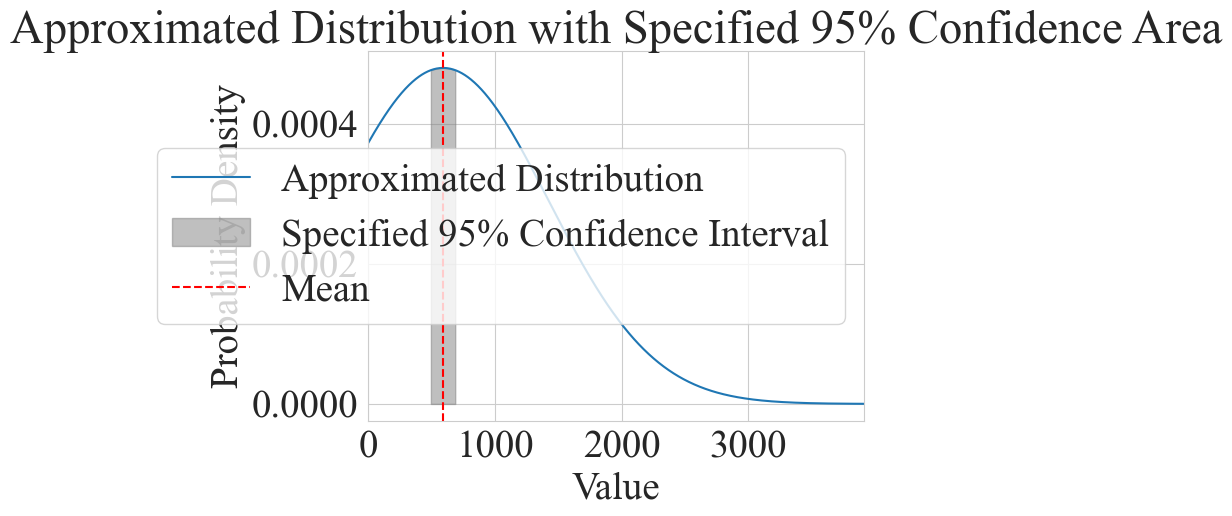

In [730]:
from scipy.stats import norm


# Given parameters
mean = 591
std_dev = 831
ci_lower = 495
ci_upper = 687


x_min = max(0, mean - 4*std_dev)
x_max = mean + 4*std_dev
x = np.linspace(x_min, x_max, 1000)
y = norm.pdf(x, mean, std_dev)
plt.plot(x, y, label='Approximated Distribution')
x_ci = np.linspace(ci_lower, ci_upper, 1000)
y_ci = norm.pdf(x_ci, mean, std_dev)
plt.fill_between(x_ci, y_ci, color='grey', alpha=0.5, label='Specified 95% Confidence Interval')
plt.axvline(mean, color='r', linestyle='--', label='Mean')

plt.xlim(0, x_max)  
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.title('Approximated Distribution with Specified 95% Confidence Area')
plt.legend()
plt.show()


In [725]:
import scipy.stats as stats

total_pv_to_load_values = [results['Total Grid to Load'] for results in results_summary.values()]
total_pv_to_load_values = total_pv_to_load_values[0]

mean_pv_to_load = np.mean(total_pv_to_load_values)
std_dev_pv_to_load = np.std(total_pv_to_load_values, ddof=1)  # ddof=1 for sample standard deviation

confidence_level = 0.95
degrees_freedom = len(total_pv_to_load_values) - 1
confidence_interval = stats.t.interval(confidence_level, degrees_freedom, mean_pv_to_load, std_dev_pv_to_load / np.sqrt(len(total_pv_to_load_values)))

print(f"Mean (Total PV to Load): {mean_pv_to_load}")
print(f"Standard Deviation (Total PV to Load): {std_dev_pv_to_load}")
print(f"95% Confidence Interval (Total PV to Load): {confidence_interval}")

Mean (Total PV to Load): 694.6544017760882
Standard Deviation (Total PV to Load): 953.1780324838035
95% Confidence Interval (Total PV to Load): (584.1037887956222, 805.2050147565542)


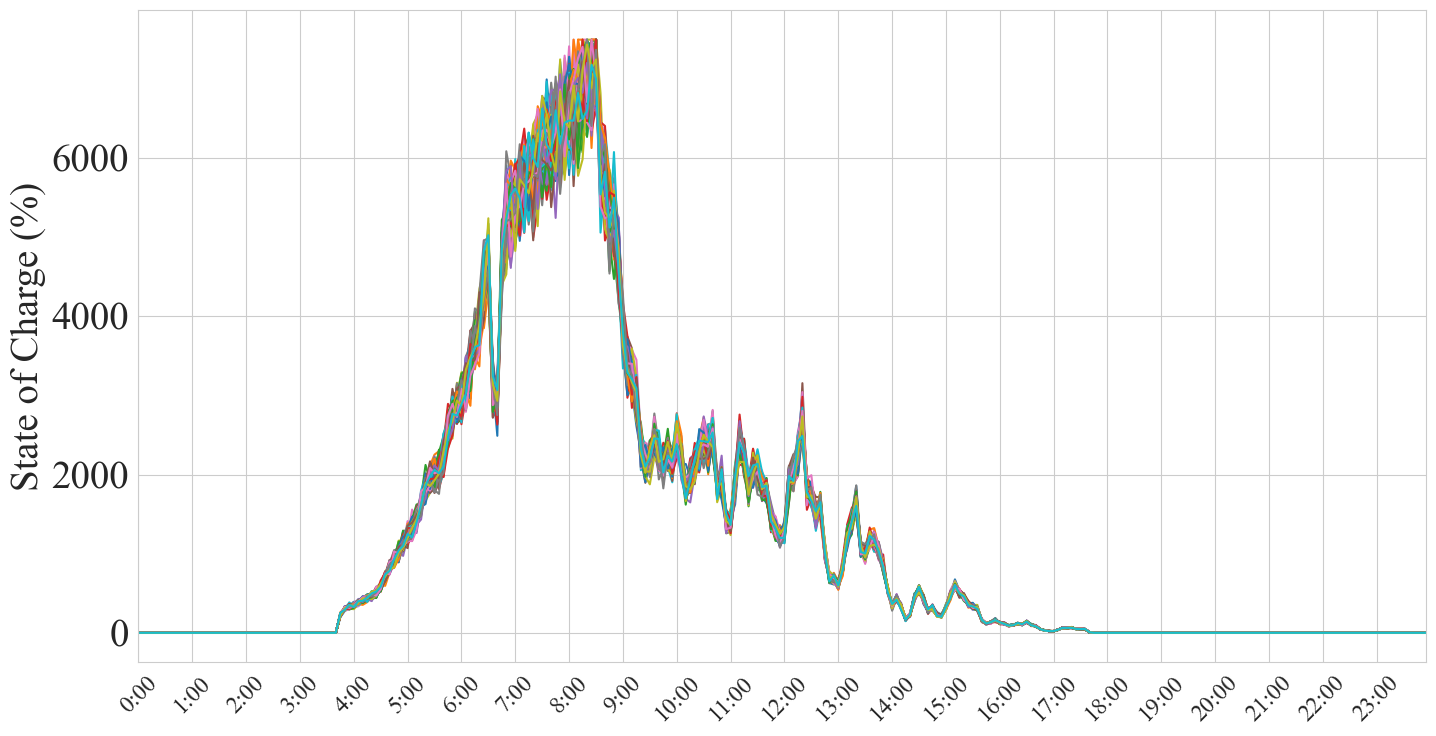

In [718]:
plt.figure(figsize=(15, 8))
for sim_key in results_summary.keys():
    soc_values = results_summary[sim_key]['PV Power']
    plt.plot(soc_values) 
plt.ylabel('State of Charge (%)')
plt.xlim([0,287])
plt.xticks(ticks=hour_ticks, labels=hour_labels, rotation=45, fontsize=17)
plt.grid(True)

folder_name = f'error_analysis'
folder_path = os.path.join(os.getcwd(), folder_name)
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
filename = f'pv_with_20%_error.svg'
path = os.path.join(folder_path, filename)
plt.tight_layout()
# plt.savefig(path, dpi=300)
plt.show()

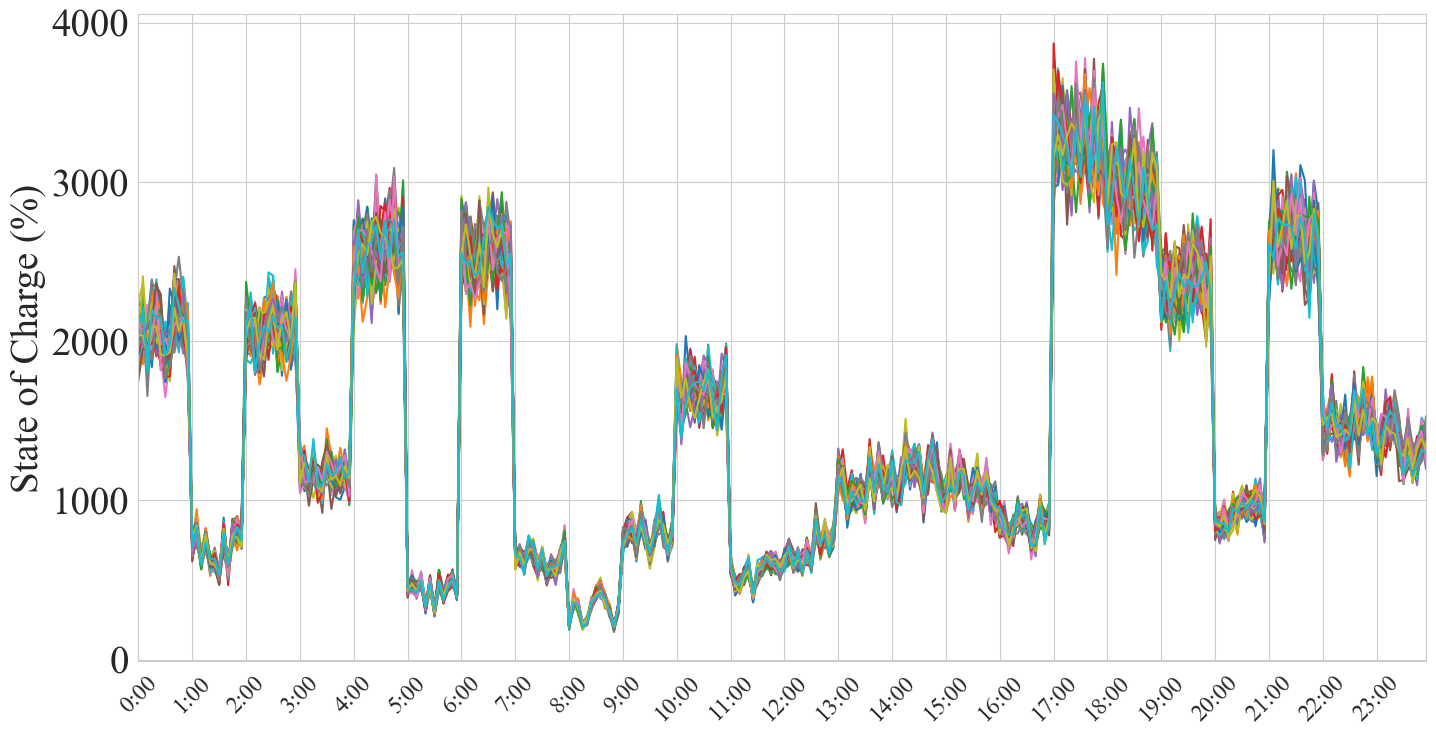

In [717]:
plt.figure(figsize=(15, 8))
for sim_key in results_summary.keys():
    soc_values = results_summary[sim_key]['Load Power']
    plt.plot(soc_values) 
plt.ylabel('State of Charge (%)')
plt.xticks(ticks=hour_ticks, labels=hour_labels, rotation=45, fontsize=17)
plt.grid(True)
plt.xlim([0,287])
folder_name = f'error_analysis'
folder_path = os.path.join(os.getcwd(), folder_name)
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
filename = f'load_with_20%_error.svg'
path = os.path.join(folder_path, filename)
plt.tight_layout()
# plt.savefig(path, dpi=300)
plt.show()

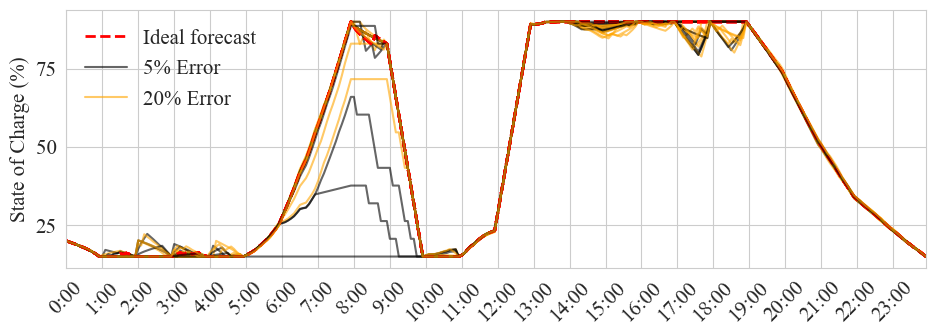

In [758]:
plt.figure(figsize=(10, 4))
for sim_key in results_summary.keys():
    plt.plot(ideal_results[sim_key]['Total SOC'],'--' ,color='red', lw=2 )
    plt.plot(five_percent_results[sim_key]['Total SOC'], color='black', alpha=0.6)
    plt.plot(ten_percent_results[sim_key]['Total SOC'], color='orange', alpha=0.6)
plt.legend(['Ideal forecast', '5% Error' , '20% Error' ], frameon=False, fontsize=15)    
plt.ylabel('State of Charge (%)', fontsize=15)
plt.xticks(ticks=hour_ticks, labels=hour_labels,rotation=45, fontsize=15)
plt.yticks(fontsize=15)
plt.xlim([0,287])
plt.grid(True)
folder_name = f'error_analysis'
folder_path = os.path.join(os.getcwd(), folder_name)
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
filename = f'soc_error_deviation.svg'
path = os.path.join(folder_path, filename)
plt.tight_layout()
# plt.savefig(path, dpi=300)
plt.show()

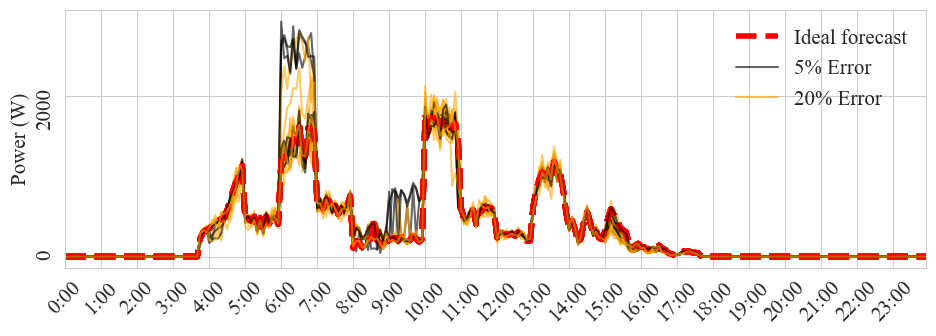

In [780]:
plt.figure(figsize=(10, 4))
for sim_key in results_summary.keys():
    plt.plot(ideal_results[sim_key]['Total PV to Load'],'--' ,color='red', lw=4 )
    plt.plot(five_percent_results[sim_key]['Total PV to Load'], color='black', alpha=0.6)
    plt.plot(ten_percent_results[sim_key]['Total PV to Load'], color='orange', alpha=0.6)
plt.ylabel('Power (W)', fontsize=15)
plt.yticks(rotation=90, fontsize=15)
plt.legend(['Ideal forecast', '5% Error' , '20% Error' ], frameon=False, fontsize=15)  
plt.grid(True)
plt.xticks(ticks=hour_ticks, labels=hour_labels,rotation=45, fontsize=15)
plt.xlim([0,287])

folder_name = f'error_analysis'
folder_path = os.path.join(os.getcwd(), folder_name)
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
filename = f'PV to Load_error_deviation.svg'
path = os.path.join(folder_path, filename)
plt.tight_layout()
# plt.savefig(path, dpi=300)
plt.show()

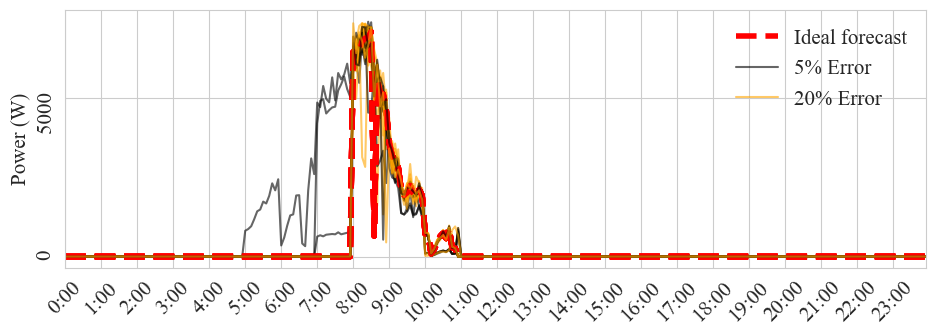

In [779]:
plt.figure(figsize=(10, 4))
for sim_key in results_summary.keys():
    plt.plot(ideal_results[sim_key]['Total PV to Grid'],'--' ,color='red', lw=4 )
    plt.plot(five_percent_results[sim_key]['Total PV to Grid'], color='black', alpha=0.6)
    plt.plot(ten_percent_results[sim_key]['Total PV to Grid'], color='orange', alpha=0.6)
plt.ylabel('Power (W)', fontsize=15)
plt.yticks(rotation=90, fontsize=15)
plt.legend(['Ideal forecast', '5% Error' , '20% Error' ], frameon=False, fontsize=15)  
plt.grid(True)
plt.xticks(ticks=hour_ticks, labels=hour_labels,rotation=45, fontsize=15)
plt.xlim([0,287])

folder_name = f'error_analysis'
folder_path = os.path.join(os.getcwd(), folder_name)
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
filename = f'PV to grid_error_deviation.svg'
path = os.path.join(folder_path, filename)
plt.tight_layout()
# plt.savefig(path, dpi=300)
plt.show()

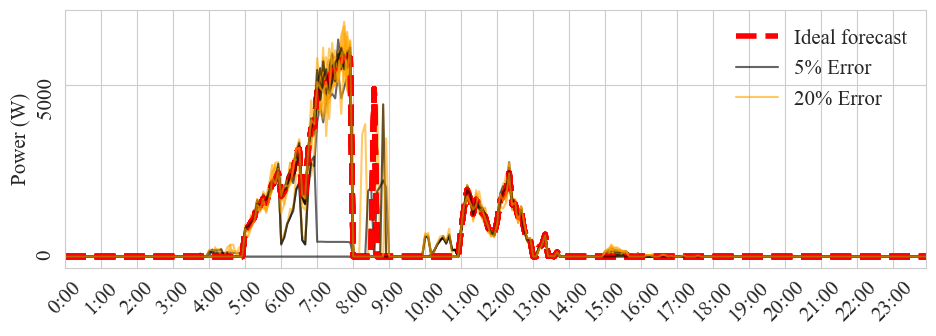

In [778]:
plt.figure(figsize=(10, 4))
for sim_key in results_summary.keys():
    plt.plot(ideal_results[sim_key]['Total PV to ESS'],'--' ,color='red', lw=4 )
    plt.plot(five_percent_results[sim_key]['Total PV to ESS'], color='black', alpha=0.6)
    plt.plot(ten_percent_results[sim_key]['Total PV to ESS'], color='orange', alpha=0.6)
plt.ylabel('Power (W)', fontsize=15)
plt.yticks(rotation=90, fontsize=15)
plt.legend(['Ideal forecast', '5% Error' , '20% Error' ], frameon=False, fontsize=15)  
plt.grid(True)
plt.xticks(ticks=hour_ticks, labels=hour_labels,rotation=45, fontsize=15)
plt.xlim([0,287])

folder_name = f'error_analysis'
folder_path = os.path.join(os.getcwd(), folder_name)
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
filename = f'PV to ess error deviation.svg'
path = os.path.join(folder_path, filename)
plt.tight_layout()
# plt.savefig(path, dpi=300)
plt.show()

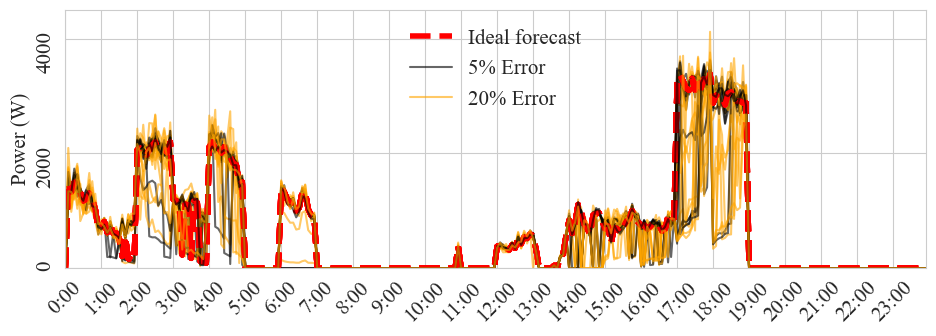

In [781]:
plt.figure(figsize=(10, 4))
for sim_key in results_summary.keys():
    plt.plot(ideal_results[sim_key]['Total Grid to Load'] ,'--' ,color='red', lw=4 ) # + ideal_results[sim_key]['Total Grid to ESS']
    plt.plot(five_percent_results[sim_key]['Total Grid to Load'], color='black', alpha=0.6) # + five_percent_results[sim_key]['Total Grid to ESS']
    plt.plot(ten_percent_results[sim_key]['Total Grid to Load'], color='orange', alpha=0.6) # + ten_percent_results[sim_key]['Total Grid to ESS']
plt.ylabel('Power (W)', fontsize=15)
plt.yticks(rotation=90, fontsize=15)
plt.legend(['Ideal forecast', '5% Error' , '20% Error' ], frameon=False, fontsize=15)  
plt.grid(True)
plt.xticks(ticks=hour_ticks, labels=hour_labels,rotation=45, fontsize=15)
plt.xlim([0,287])
plt.ylim([0,4500])

folder_name = f'error_analysis'
folder_path = os.path.join(os.getcwd(), folder_name)
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
filename = f'Grid to load error deviation.svg'
path = os.path.join(folder_path, filename)
plt.tight_layout()
# plt.savefig(path, dpi=300)
plt.show()

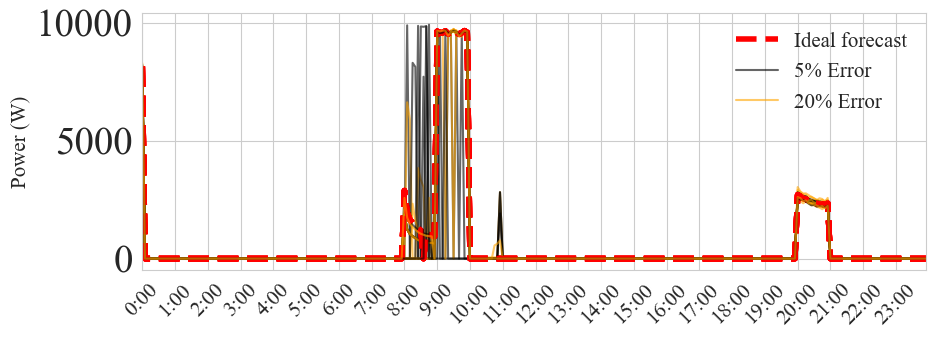

In [774]:
plt.figure(figsize=(10, 4))
for sim_key in results_summary.keys():
    plt.plot(ideal_results[sim_key]['Total ESS to Grid'] + ideal_results[sim_key]['Total PV to Grid'],'--' ,color='red', lw=4 )
    plt.plot(five_percent_results[sim_key]['Total ESS to Grid']+ five_percent_results[sim_key]['Total PV to Grid'], color='black', alpha=0.6)
    plt.plot(ten_percent_results[sim_key]['Total ESS to Grid']+ ten_percent_results[sim_key]['Total PV to Grid'], color='orange', alpha=0.6)
plt.ylabel('Power (W)', fontsize=15)
plt.legend(['Ideal forecast', '5% Error' , '20% Error' ], frameon=False, fontsize=15)  
plt.grid(True)
plt.xticks(ticks=hour_ticks, labels=hour_labels,rotation=45, fontsize=15)
plt.xlim([0,287])
# plt.ylim([0,4500])

folder_name = f'error_analysis'
folder_path = os.path.join(os.getcwd(), folder_name)
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
filename = f'Grid to Load_20%_error.svg'
path = os.path.join(folder_path, filename)
plt.tight_layout()
# plt.savefig(path, dpi=300)
plt.show()

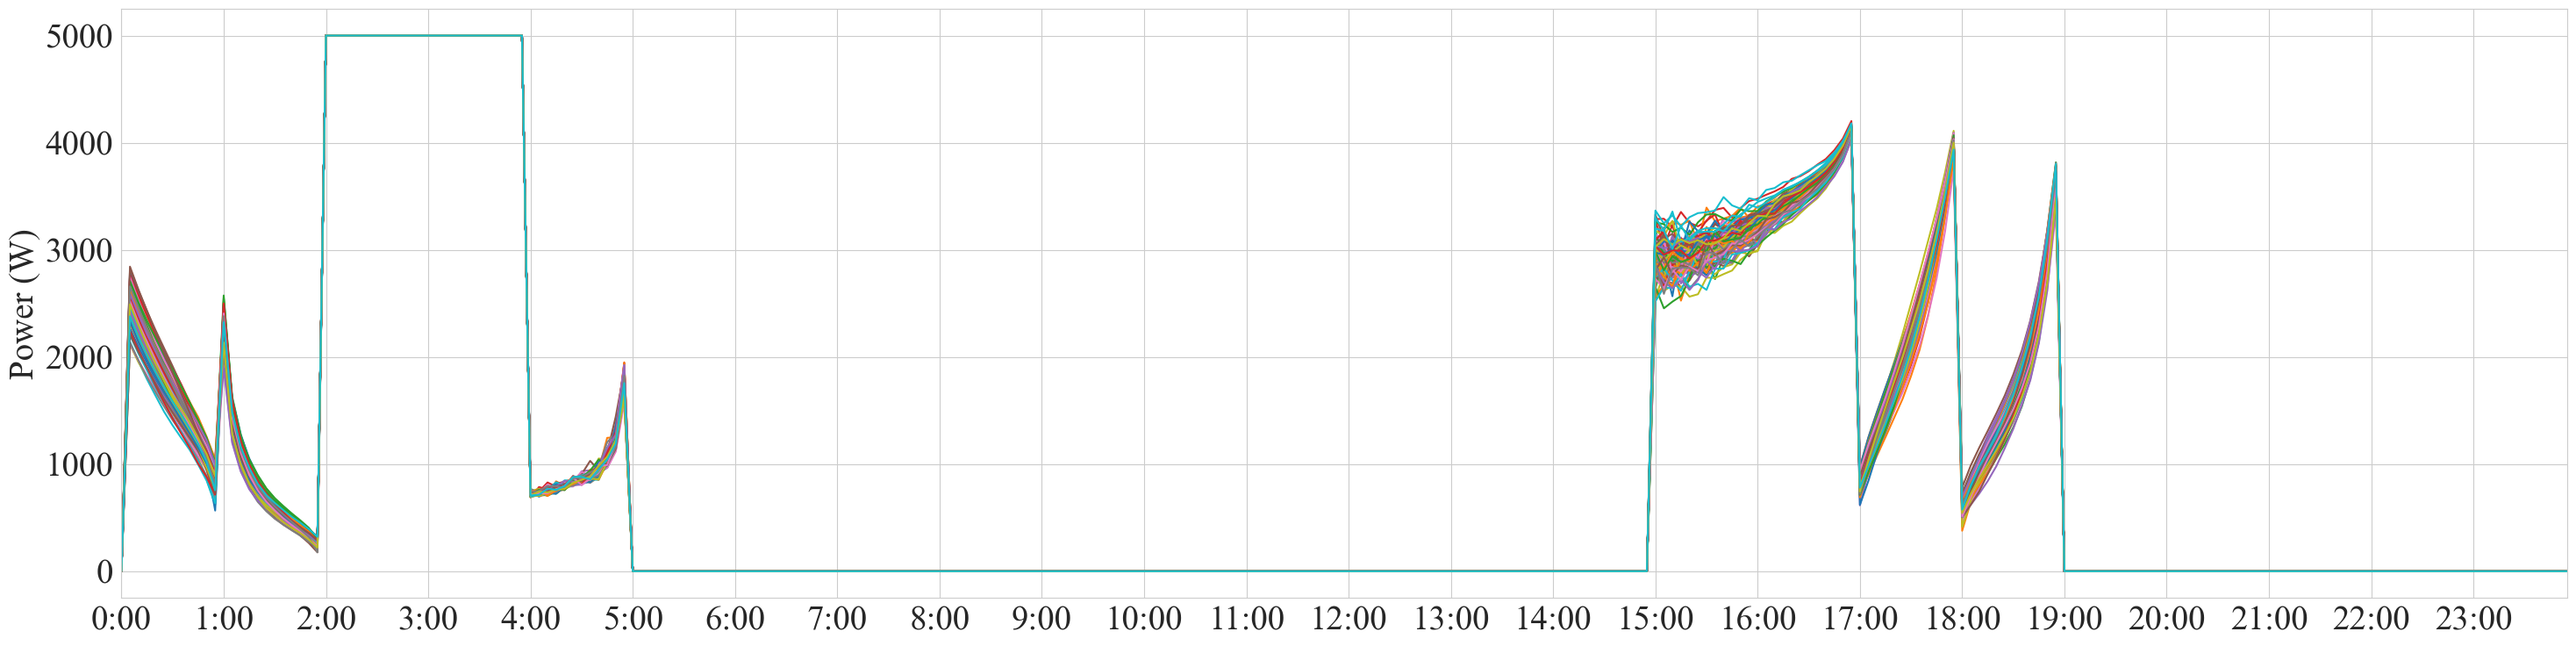

In [684]:
plt.figure(figsize=(30, 8))
for sim_key in results_summary.keys():
    soc_values = results_summary[sim_key]['Total Grid to ESS']
    plt.plot(soc_values)
plt.ylabel('Power (W)')
plt.grid(True)
plt.xticks(ticks=hour_ticks, labels=hour_labels)
plt.xlim([0,287])

folder_name = f'error_analysis'
folder_path = os.path.join(os.getcwd(), folder_name)
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
filename = f'Grid to ESS_20%_error.svg'
path = os.path.join(folder_path, filename)
plt.tight_layout()
# plt.savefig(path, dpi=300)
plt.show()

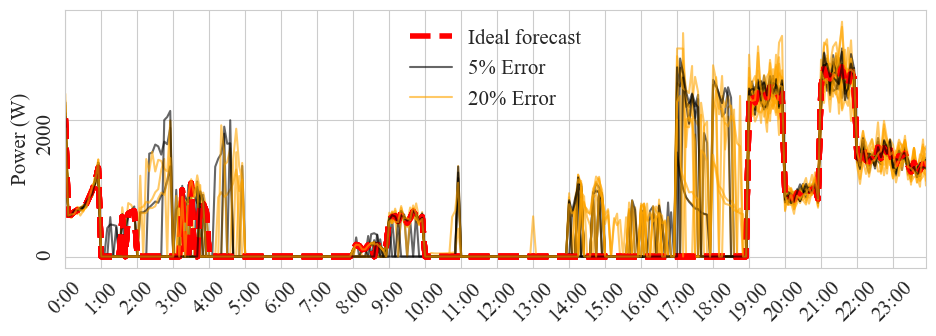

In [784]:
plt.figure(figsize=(10, 4))
for sim_key in results_summary.keys():
    plt.plot(ideal_results[sim_key]['Total ESS to Load'],'--' ,color='red', lw=4 )
    plt.plot(five_percent_results[sim_key]['Total ESS to Load'], color='black', alpha=0.6)
    plt.plot(ten_percent_results[sim_key]['Total ESS to Load'], color='orange', alpha=0.6)
plt.ylabel('Power (W)', fontsize=15)
plt.yticks(rotation=90, fontsize=15)
plt.legend(['Ideal forecast', '5% Error' , '20% Error' ], frameon=False, fontsize=15)  
plt.grid(True)
plt.xticks(ticks=hour_ticks, labels=hour_labels,rotation=45, fontsize=15)
plt.xlim([0,287])
# plt.ylim([0,4500])

folder_name = f'error_analysis'
folder_path = os.path.join(os.getcwd(), folder_name)
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
filename = f'ESS to Load error deviation.svg'
path = os.path.join(folder_path, filename)
plt.tight_layout()
plt.savefig(path, dpi=300)
plt.show()

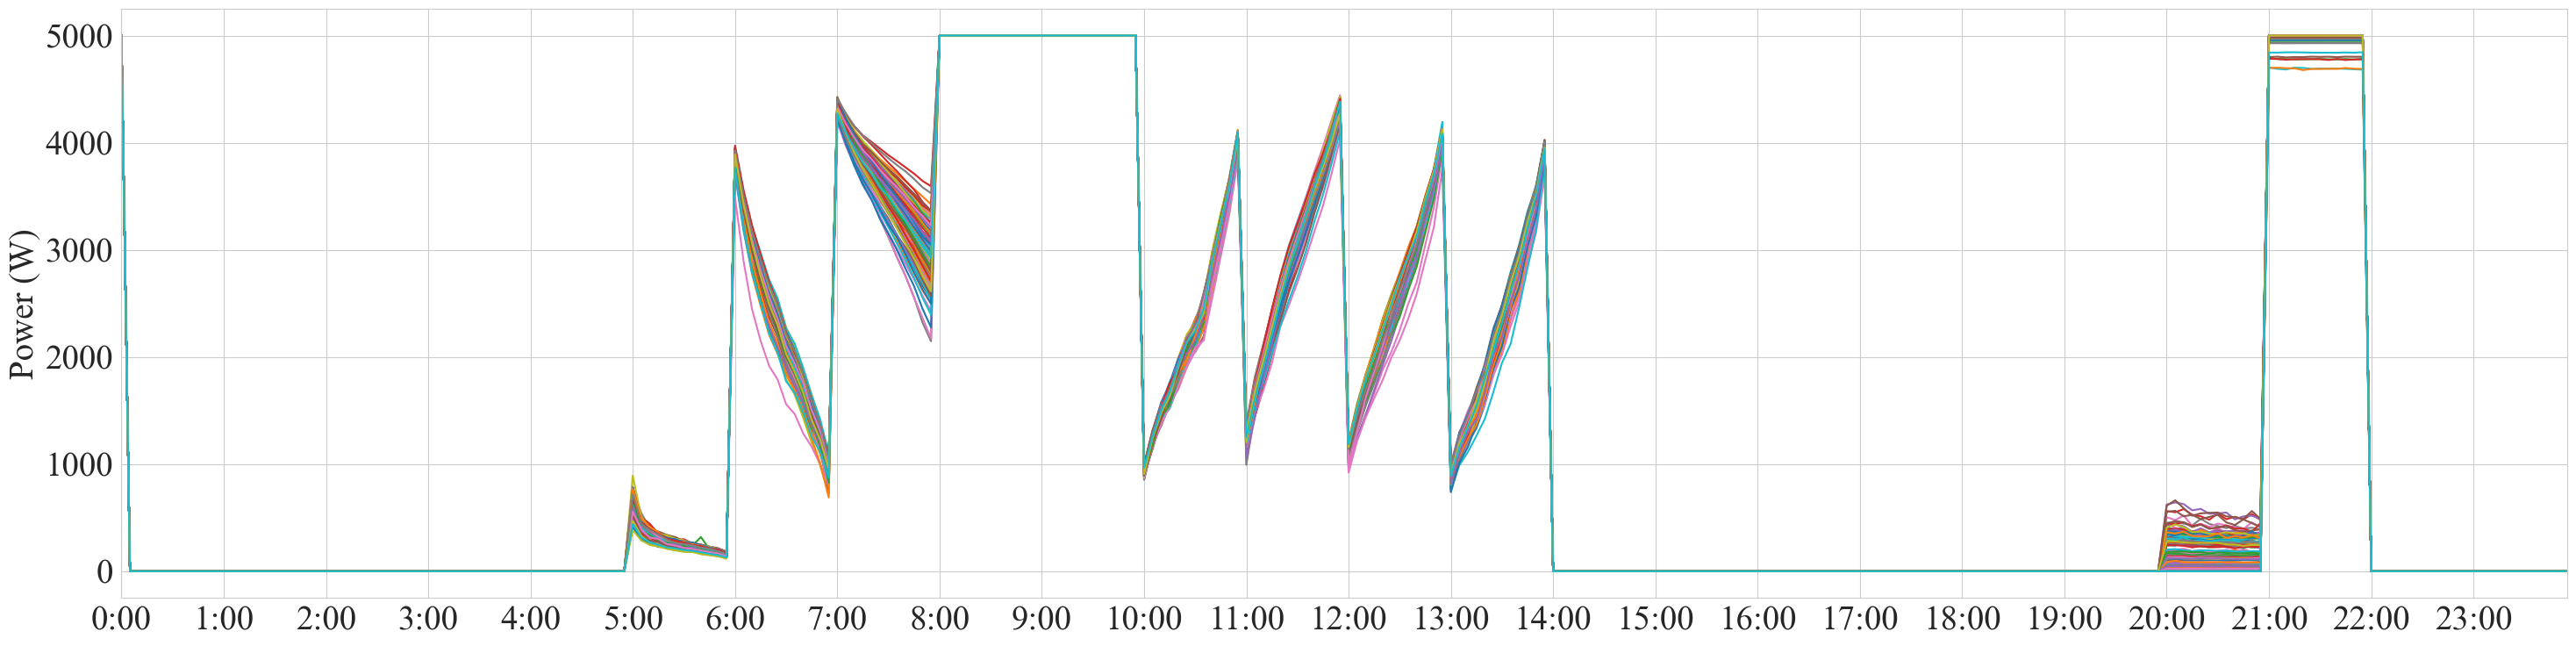

In [686]:
plt.figure(figsize=(10, 4))
for sim_key in results_summary.keys():
    soc_values = results_summary[sim_key]['Total ESS to Grid']
    plt.plot(soc_values)
plt.ylabel('Power (W)')
plt.grid(True)
plt.xticks(ticks=hour_ticks, labels=hour_labels)
plt.xlim([0,287])

folder_name = f'error_analysis'
folder_path = os.path.join(os.getcwd(), folder_name)
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
filename = f'ESS to Grid_20%_error.svg'
path = os.path.join(folder_path, filename)
plt.tight_layout()
# plt.savefig(path, dpi=300)
plt.show()